In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Allow load project as module
sys.path.insert(0, '..')

In [3]:
import os
import copy
import getpass
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd 
import h5py
from matplotlib.colors import LogNorm

In [4]:
from scipy.stats import rv_continuous
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd

In [5]:
os.environ['PFSSPEC_DATA'] = r'/scratch/ceph/dobos/data/pfsspec'
os.environ['PYSYN_CDBS'] = os.path.join(os.environ['PFSSPEC_DATA'], 'cdbs')

In [6]:
import matplotlib     
matplotlib.rcParams.update({'font.size': 14})

# Load BOSZ stellar model grid

In [7]:
from pfsspec.stellarmod.boszgrid import BoszGrid

In [8]:
fn = os.path.join(os.environ['PFSSPEC_DATA'], 'import/stellar/grid/bosz_5000/spectra.h5')
with h5py.File(fn, 'r') as f:
    print(f['flux'].shape, f['flux'].dtype, f['flux'].chunks)
    print(f['flux_idx'].shape, f['flux_idx'].dtype, f['flux_idx'].chunks)

(14, 67, 11, 6, 4, 16094) float64 (1, 1, 1, 1, 1, 16094)
(14, 67, 11, 6, 4) bool None


In [ ]:
grid = BoszGrid()
grid.preload_arrays = False
grid.load(fn, format='h5')

In [10]:
grid.__dict__.keys()

dict_keys(['jsonomit', 'file', 'filename', 'fileformat', 'filedata', 'preload_arrays', 'params', 'data', 'data_shape', 'data_index', 'wave'])

### Work with smaller grid first
    -CM =0, OM = 0
    - wavelength in (3900, 6900)
    -log(g) > 2.0
    -Teff < 10000k

    Only explore sampling in Teff, [Fe/H], logg direction

In [11]:
grid_idx_CM = np.where(grid.params['C_M'].values == 0)[0][0]
grid_idx_OM = np.where(grid.params['O_M'].values == 0)[0][0]
grid_idx_Teff =np.where(grid.params['T_eff'].values <=10000)[0][-1]
grid_idx_log =np.where(grid.params['log_g'].values >=2 )[0][0]

grid_idx_CM, grid_idx_OM, grid_idx_Teff, grid_idx_log

(3, 1, 26, 4)

In [361]:
lg_paras = grid.params["log_g"].values[grid_idx_log:]
Te_paras = grid.params["T_eff"].values[:grid_idx_Teff]
Fe_paras = grid.params["Fe_H"].values
para_dict = {}
para_dict["lg"] = lg_paras
para_dict["Te"] = Te_paras
para_dict["Fe"] = Fe_paras



In [320]:
grid_idx_wave0 = np.where(grid.wave > 3900 )[0][0]
grid_idx_wave1 = np.where(grid.wave > 6900 )[0][0]

In [321]:
flux3 = copy.deepcopy(grid.data["flux"][:,:grid_idx_Teff,grid_idx_log:,grid_idx_CM,grid_idx_OM, grid_idx_wave0:grid_idx_wave1])
flux3_mask = grid.data_index['flux'][:,:grid_idx_Teff, grid_idx_log:,grid_idx_CM, grid_idx_OM] 
flux3.shape, flux3_mask.shape


((14, 26, 7, 5706), (14, 26, 7))

In [531]:
np.save("flux3", flux3)

In [532]:
np.save("flux3_mask", flux3_mask)

In [536]:
grid_wv =grid.wave[grid_idx_wave0:grid_idx_wave1]

In [537]:
grid_wv

array([3900.0908, 3900.481 , 3900.8711, ..., 6898.4648, 6899.1548,
       6899.8447])

In [538]:
np.save("grid_wv", grid_wv)

In [533]:
flux3 = np.load("flux3.npy")
flux3_mask = np.load("flux3_mask.npy")

In [ ]:
grid_wv = np.load("grid_wv.npy")

## Interpolating at a single line 
### - H$\alpha$ line at 6562.8 A (air)
### - Our grid.wave is in air

In [456]:
def get_air(vac):  
    fac = (1.0 + 2.735182*10**(-4) + 131.4182 / vac**2 + 2.76249*10**8 / vac**4)
#     print(fac)
    air = vac / fac
    
    return np.round(air,2)
def get_vac(air):  
    sigma2 = 1.0e+8 / (air * air);
    n = 1 + 6.4328e-5 + 2.94981e-2 / (146.0 - sigma2) + 2.5540e-4 / (41.0 - sigma2);
    return air * n

In [408]:
def get_lineidx(line, grid_wv = grid_wv, vac = True):
    if vac:
        line = get_air(line)
    print('wv in air',line)
    line_idx = np.argsort(abs(grid_wv - line))[:1][0]
    return line_idx

In [409]:
def plot_Fe_line(flux, para_str, para_dict = para_dict, line_idx = line_idx, grid_wv = grid_wv, idx_Fe_H =10, idx_Teff = 6, idx_log = 3, ds = 20 ,ax = plt):
    paras = para_dict[para_str]
    ax.plot( grid_wv[(line_idx-ds ): (line_idx+ ds)], flux[idx_Fe_H,idx_Teff,idx_log, (line_idx- ds ): (line_idx+ ds)], c = 'deepskyblue', label = f'{para_str}= {paras[idx_Fe_H]}')
    ax.axvline(grid_wv[line_idx], c ='g', label = f'H+alpha{np.round(grid_wv[line_idx])}')
#     ax.set_ylim([320000, 410000])
    ax.legend(loc = 3)

wv in air 6562.8


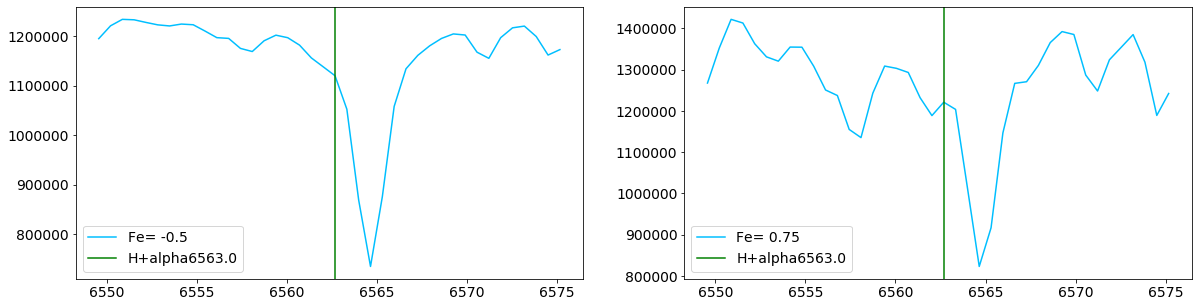

In [411]:
line_idx_Fe = get_lineidx(6562.8, vac = False)
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (20,5))
plot_Fe_line(flux3, line_idx = line_idx_Fe, para_str = 'Fe',idx_Fe_H = 8, ax = ax0)
plot_Fe_line(flux3, line_idx = line_idx_Fe, para_str = 'Fe', idx_Fe_H = -1, ax = ax1)

In [524]:
def plot_Lg_line(flux, para_str, para_dict = para_dict, line_idx = line_idx, grid_wv = grid_wv, idx_Fe_H =10, idx_Teff = 6, idx_log = 3, ds = 20 ,ax = plt):
    paras = para_dict[para_str]
    ax.plot( grid_wv[(line_idx-ds ): (line_idx+ ds)], flux[idx_Fe_H,idx_Teff,idx_log, (line_idx- ds ): (line_idx+ ds)], c = 'deepskyblue', label = f'{para_str}= {paras[idx_log]}')
    ax.axvline(grid_wv[line_idx], c ='g', label = 'Ca I L+')
    ax.set_ylim([1000000, 2000000])
    ax.legend(loc = 3)

wv in air 6502


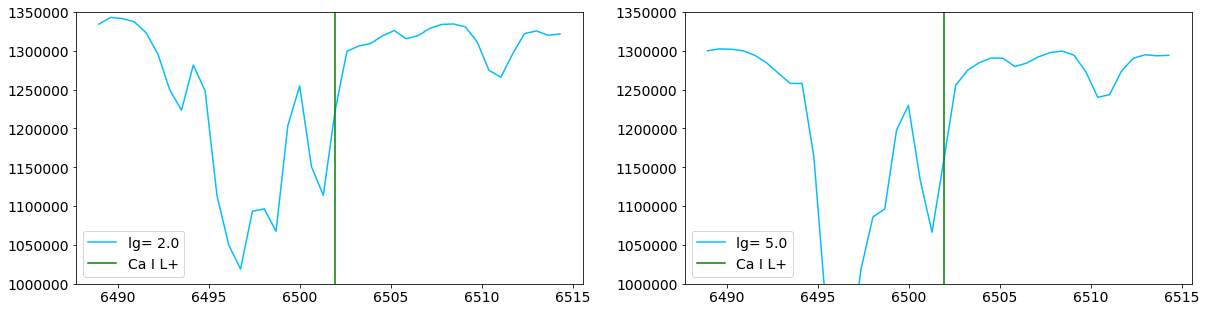

In [499]:
line_idx_lg = get_lineidx(6278.9268, vac = False)
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (20,5))
plot_Lg_line(flux3,line_idx =line_idx_lg,  para_str = 'lg',idx_log = 0, ax = ax0)
plot_Lg_line(flux3, line_idx =line_idx_lg, para_str = 'lg', idx_log = -1, ax = ax1)

wv in air 6278.9268


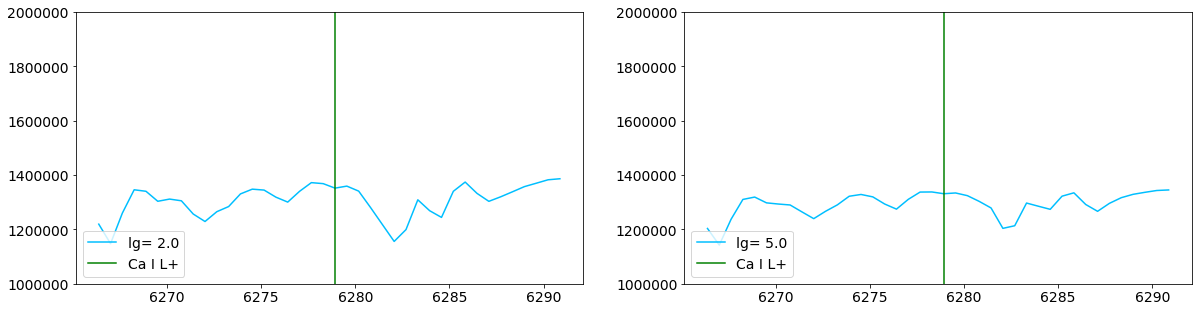

In [525]:
line_idx_lg = get_lineidx(6278.9268, vac = False)
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (20,5))
plot_Lg_line(flux3,line_idx =line_idx_lg,  para_str = 'lg',idx_log = 0, ax = ax0)
plot_Lg_line(flux3, line_idx =line_idx_lg, para_str = 'lg', idx_log = -1, ax = ax1)

### I. 1D case
    - GOAL: determine interpolation method of parameters: Simplex or Gradient?
    - GOAL: determine contraction method of wavelength direction: Max, 95%, or median?

#### I.I 1D grid & mask
    - Fixing 2 out of 3 at T_eff = 5000K log(g) = 3.5, [Fe/H] = 0

In [501]:
Te_paras

array([3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000,
       6250, 6500, 6750, 7000, 7250, 7500, 7750, 8000, 8250, 8500, 8750,
       9000, 9250, 9500, 9750])

In [502]:
idx_Teff1 =np.where(Te_paras ==9750)[0][0]
idx_log =np.where(lg_paras == 3.5 )[0][0]
idx_Fe =np.where(Fe_paras == 0 )[0][0]

idx_Fe,idx_Teff1, idx_log

(10, 25, 3)

In [503]:
# fluxH1D = flux3[:,idx_Teff1,idx_log]
fluxH1D = flux3[idx_Fe,idx_Teff1,:]
maskH1D = flux3_mask[idx_Fe,idx_Teff1,:]
fluxH1D, fluxH1D.shape

(array([[46585000., 46788000., 46618000., ...,  9560100.,  9555600.,
          9550800.],
        [47275000., 47345000., 47138000., ...,  9522100.,  9518000.,
          9513700.],
        [45392000., 45386000., 45203000., ...,  9513200.,  9509400.,
          9505300.],
        ...,
        [36014000., 36012000., 35999000., ...,  9599900.,  9596500.,
          9592500.],
        [31384000., 31312000., 31275000., ...,  9678600.,  9675400.,
          9671400.],
        [28122000., 27977000., 27891000., ...,  9764900.,  9761700.,
          9757700.]]),
 (7, 5706))

In [504]:
def get_params_dx(para_str):
    paras = grid.params[para_str].values  
    print(para_str, paras)
    dx = paras[1]-paras[0]
    print('dx', dx)
    return paras, dx
    
def get_grads(fluxH1D, maskH1D):
    head, mid, tail = fluxH1D[:-2,:], fluxH1D[1:-1,:], fluxH1D[2:,:]
    laplace = (head + tail - 2 * mid)/2
    fluxH1D[~maskH1D] = nan
    grad = np.abs(np.gradient(fluxH1D, 1,axis = 0))
    grad[np.isnan(grad)] = 0
    laplace[np.isnan(laplace)] = 0
    fluxH1D[np.isnan(fluxH1D)] = 0    
    laplace_frac = np.divide(laplace, fluxH1D[1:-1,:])
    return grad, laplace, laplace_frac

def get_rel_grads(grad, fluxH1D):
    return np.divide(grad, fluxH1D)

In [505]:
grad0_1d, laplace_1d, laplace_frac  = get_grads(fluxH1D, maskH1D)

In [506]:
laplace_1d.shape

(5, 5706)

#### I.II Determing contraction method along wavelength diretion

Laplacian : $\Delta f = (f_{n+1}+f_{n-1} - 2f_{n})/ 2 $

In [507]:
def get_sensitive_lines(data, operator_str, para_str, x_paras, log_hist = True):
    l_para,l_wave = np.shape(data)
    fig, axs = plt.subplots(1,int(l_para), figsize = (22,5), sharey = True, sharex = True)
    i = 0
    for ax in axs.flatten():
        data_per_para = data[i]
        ax.hist(data_per_para,log = log_hist, bins = 100, label = f'{para_str}: {x_paras[i+1]}' )
        ax.legend(loc = 2)
    #     ax.set_ylim([0,1])
    #     ax.set_xlim([-0.1,0.1])
        i +=1        
    fig.suptitle(f'Distribution of flux {operator_str} over {l_wave} lines (Log {log_hist})')


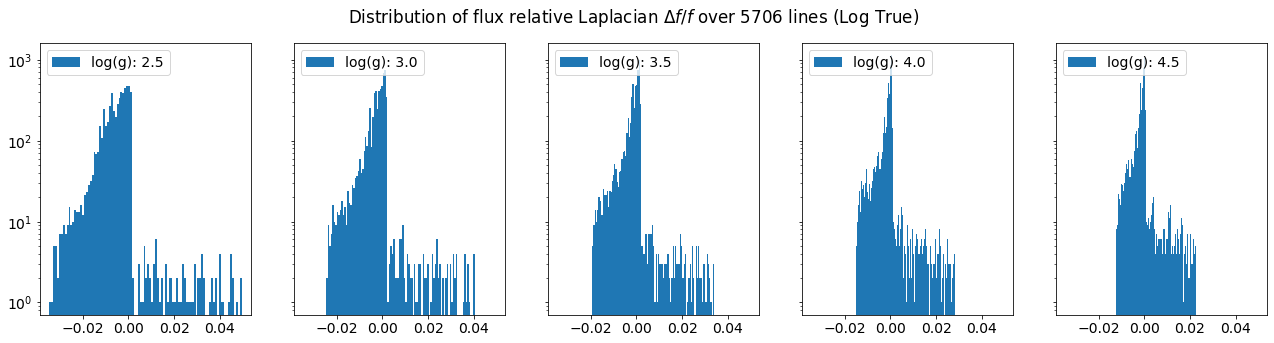

In [508]:
get_sensitive_lines(laplace_frac, "relative Laplacian $\Delta f / f$", "log(g)", lg_paras, log_hist = True)

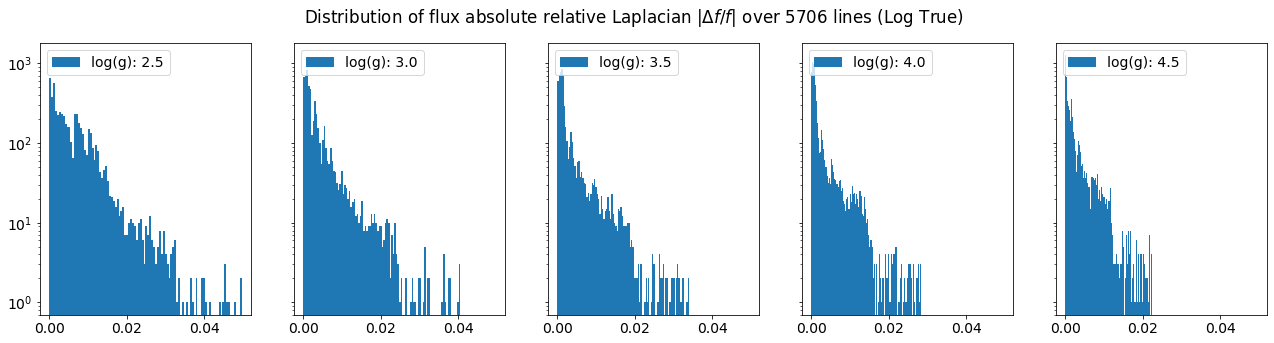

In [509]:
get_sensitive_lines(abs(laplace_frac), "absolute relative Laplacian $|\Delta f / f|$", "log(g)", lg_paras, log_hist = True)

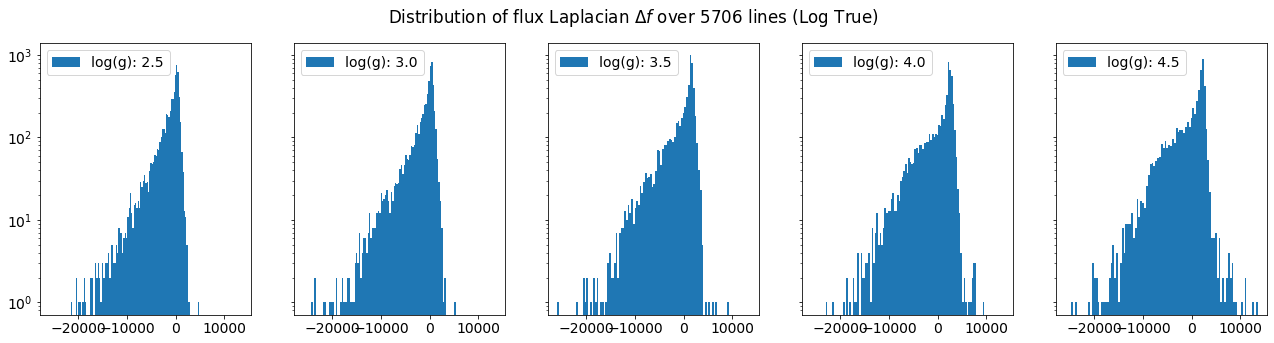

In [423]:
get_sensitive_lines(laplace_1d, "Laplacian $\Delta f$", "log(g)", lg_paras, log_hist = True)

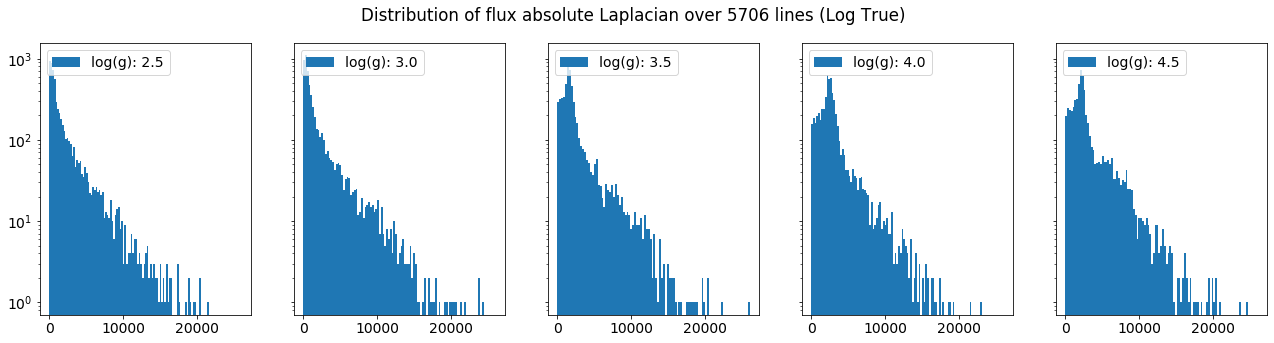

In [424]:
get_sensitive_lines(abs(laplace_1d), "absolute Laplacian", "log(g)", lg_paras, log_hist = True)

In [510]:
def get_sensitive_lines_wv_dict(paras, para_str, data, grid_wave = grid_wv, cutoff = 100):
    sline_dict = {}
    for sline_para_idx, para_val in enumerate(paras[1:-1]):
        print(f"looking at sensitive lines at {para_val}" , end = " ")
        sline_idxs = np.argsort(abs(data)[sline_para_idx])[:cutoff]
        sline_wv = grid_wv[sline_idxs]
        print(f'top {sline_wv.shape} lines')
        sline_dict[f'{para_str}{para_val}'] = sline_wv
    print(sline_dict.keys())
    return sline_dict

In [521]:
sline_idxs = np.argsort(abs(laplace_frac)[sline_para_idx])[:cutoff]

NameError: name 'sline_para_idx' is not defined

In [516]:
laplace_frac = abs(laplace_frac)

In [522]:
sline_dict100

{'logg2.5': array([6278.9268, 6304.0928, 6281.4385, 6282.0674, 6283.3232, 6316.7134,
        6316.082 , 6283.9521, 6284.5806, 6277.6709, 6604.1553, 6286.4658,
        6287.0947, 6290.2393, 6292.1265, 6294.6436, 6194.1113, 6298.4219,
        6302.832 , 6285.209 , 6277.0435, 6303.4624, 6434.6602, 6215.8291,
        6261.9966, 6404.4883, 6464.3281, 6270.1421, 6157.0581, 6194.731 ,
        6216.4507, 6257.6147, 6261.3701, 6264.502 , 6265.1279, 6265.7549,
        6266.3818, 6267.0078, 6269.5156, 6270.7695, 6273.9058, 6272.6509,
        6274.5332, 6275.1606, 6276.416 , 6278.2988, 6280.1826, 6280.8105,
        6282.6953, 6285.8374, 6291.4971, 6290.8682, 6296.5327, 6295.2734,
        6295.9028, 6299.0518, 6300.9419, 6301.5718, 6305.354 , 6304.7236,
        6308.5068, 6309.7695, 6310.3999, 6313.5557, 6314.1875, 6314.8188,
        6315.4502, 6317.3447, 6317.9775, 6321.7686, 6335.6924, 6320.5049,
        6334.4248, 6347.1064, 6350.2808, 6374.458 , 6371.9087, 6386.5811,
        6387.2197, 6399.367

In [517]:
sline_dict100 = get_sensitive_lines_wv_dict(lg_paras, 'logg', laplace_frac, cutoff = 100)
sline_dict500 = get_sensitive_lines_wv_dict(lg_paras, 'logg', laplace_frac, cutoff = 500)

looking at sensitive lines at 2.5 top (100,) lines
looking at sensitive lines at 3.0 top (100,) lines
looking at sensitive lines at 3.5 top (100,) lines
looking at sensitive lines at 4.0 top (100,) lines
looking at sensitive lines at 4.5 top (100,) lines
dict_keys(['logg2.5', 'logg3.0', 'logg3.5', 'logg4.0', 'logg4.5'])
looking at sensitive lines at 2.5 top (500,) lines
looking at sensitive lines at 3.0 top (500,) lines
looking at sensitive lines at 3.5 top (500,) lines
looking at sensitive lines at 4.0 top (500,) lines
looking at sensitive lines at 4.5 top (500,) lines
dict_keys(['logg2.5', 'logg3.0', 'logg3.5', 'logg4.0', 'logg4.5'])


## NIST Atomic Spectra Database (https://www.nist.gov/pml/atomic-spectra-database)

In [427]:
from astropy import units as u
from astroquery.atomic import AtomicLineList as Atm
from astroquery.atomic import Transition as T
import warnings
warnings.filterwarnings("ignore")

In [428]:
def get_high_aki(ll0, lb = '0', getall = True):
    ll0 = ll0.to_pandas()
    ll0["TF"] = 0
    for idx, aki in enumerate (ll0['A_ki']):
        try:
            last = aki[-1]
        except:
            continue
        if (last >= lb and last <= '9'):
            if getall or (ll0['SPECTRUM'][idx][-2:] == " I"):
                ll0["TF"][idx] = 1
    result = ll0[ll0["TF"] == 1]
    print(result)
    vals = []
    for val in result['LAMBDA AIR ANG'].values:
        try:
            vals.append(np.float(val))
        except:
            vals.append(np.float(val[:-1]))
    print(vals)
    return result, vals

def get_high_aki_H(ll0, lb = '0', getall = True):
    ll0 = ll0.to_pandas()
    ll0["TF"] = 0
    if getall or (ll0['SPECTRUM'][idx][-2:] == " I"):
        ll0["TF"][idx] = 1
    result = ll0[ll0["TF"] == 1]
    print(result)
    vals = []
    for val in result['LAMBDA AIR ANG'].values:
        try:
            vals.append(np.float(val))
        except:
            vals.append(np.float(val[:-1]))
    print(vals)
    return result, vals


In [429]:
wv_rg = (390 * u.nm, 800 * u.nm)

In [430]:
ll0 = Atm.query_object(wv_rg, wavelength_type='Air', wavelength_accuracy=20, element_spectrum = "H", output_columns = ('spec',"type","prob","ener"))


In [390]:
ll0.to_pandas()['LAMBDA AIR ANG'].values

array([3970.072, 4101.734, 4340.464, 4861.325, 6562.8  ])

In [179]:
ll0 = Atm.query_object(wv_rg, wavelength_type='Air', wavelength_accuracy=20, element_spectrum = "H", output_columns = ('spec',"type","prob","ener"))
ll0, ll0_vals = get_high_aki(ll0, '0', True)

Empty DataFrame
Columns: [LAMBDA VAC ANG, SPECTRUM, TT, A_ki, LEVEL ENERGY  CM 1, TF]
Index: []
[]


In [125]:
linedict = {}
linedict['H'] = [4102.892, 4341.684,4862.683,6564.61]
linedict['He'] = [4201.015, 4472.72514,4472.72884, 4472.72909, 4472.74043, 4472.74413, 4472.93808, 4542.864, 4687.02 ]
linedict['O'] = [4650.4365, 4651.6]
#alkali lines
linedict['Na I'] = [4129.0706, 4130.6737, 4132.0045, 4133.6098, 4134.1413, 4136.0188, 4137.0824, 4138.9625, 4140.0969, 4142.3152, 4143.0465, 4145.2679, 4147.1572, 4149.805, 4150.1169, 4152.7684, 4155.6152, 4158.5869, 4158.8114, 4161.7877, 4165.8682, 4168.8546, 4169.7768, 4172.7688, 4178.4672, 4181.4717, 4183.3189, 4186.3304, 4194.1939, 4197.221, 4200.3214, 4203.3574, 4214.1881, 4217.2443, 4222.0875, 4225.1551, 4240.181, 4243.275, 4250.608, 4253.717, 4274.846, 4277.99, 4289.046, 4292.212, 4322.616, 4325.832, 4342.71, 4345.955, 4391.256, 4394.574, 4421.125, 4424.489, 4495.441, 4498.919, 4542.907, 4546.458, 4666.1165, 4669.8635, 4669.8664, 4749.269, 4753.1508, 4979.9304, 4984.1986, 4984.2036, 5150.2726, 5154.8379]
linedict['Mg I'] = [3939.515, 3985.339, 3987.8808, 4055.833, 4058.6512, 4166.275, 4168.4461, 4353.129, 4355.752, 4704.3068, 4731.3517, 5168.7605, 5174.1251, 5185.0479, 5347.463, 5511.128, 5529.9403, 5712.6725, 5786.9175, 5787.1653, 5787.2762, 5861.659, 5952.747]
linedict['Al I'] = [3945.1224, 3962.641, 5108.9402, 5109.3634, 5558.6026, 5559.488]
linedict['Si I'] = [3906.62754]

# linedict['K'] = [] ???
# linedict['Ca'] = [3934.777, 3969.591, 4227.9179]
linedict['Ca'] = [3947.1499, 3950.0181, 3958.1735, 3973.693, 3974.8317, 4058.681, 4060.0598, 4060.6833, 4061.3598, 4061.687, 4062.9766, 4063.6539, 4066.5686, 4085.227, 4093.143, 4093.787, 4096.0811, 4096.1179, 4099.685, 4099.7319, 4099.7687, 4109.685, 4133.691, 4139.058, 4204.3009, 4227.9179, 4241.6513, 4284.2157, 4290.5736, 4292.458, 4300.1977, 4303.738, 4308.9556, 4313.5519, 4319.8662, 4356.3031, 4426.6795, 4435.017, 4436.2022, 4436.9245, 4456.0289, 4457.1376, 4457.8668, 4497.435, 4506.2845, 4507.8858, 4508.671, 4509.1089, 4510.7122, 4513.5334, 4579.8337, 4582.6788, 4582.7511, 4587.1505, 4587.249, 4587.3214, 4686.5789, 4848.6649, 4879.4881]
linedict['Fe'] = [4325]
# linedict['Fe'] = [4325, 4373.32,4373.50, 4373.53, 4373.73]


In [452]:
get_air(np.array([3,2]))

array([8.79637169e-07, 1.15837296e-07])

In [459]:
get_air(np.array([4385,4440,4490,4532,4592,4640, 4861, 4920,5015,5270,5333, 5780]))

array([4383.77, 4438.75, 4488.74, 4530.73, 4590.71, 4638.7 , 4859.64,
       4918.63, 5013.6 , 5268.53, 5331.52, 5778.4 ])

In [463]:
linedict_logg = {}
linedict_logg['CN'] = [4150,4216]
linedict_logg['MgH'] = [4900, 5200]
linedict_logg['FeIMgI'] = [4640,4700]
linedict_logg['CaH'] = [6345,6388]
linedict_logg2 = {}
linedict_logg2['Fe I'] = [4383.77, 4438.75, 4488.74, 4530.73, 4590.71, 4638.7 , 4859.64, 4918.63, 5013.6 , 5268.53, 5331.52, 5778.4 ]
linedict_logg2['H'] = [3970.072, 4101.734, 4340.464, 4861.325, 6562.8]
linedict_logg2['Ca I'] = [6500.2 , 6159.29, 5588.45, 4590.71, 4438.75]
linedict_logg2['MgHTiO'] = get_air(np.array([4787]))
linedict_logg2['MgI'] = get_air(np.array([5174]))
linedict_logg2['TiO'] =  get_air(np.array([5165]))
linedict_logg2['CaH2'] = [6820, 6824]


In [514]:
def get_slines_hist(dict_key,sline_dict, linebanddict,linedict, l_grid_wv = 5706, ub = 6900, lb = 3900, step = 200):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    color = iter(prop_cycle.by_key()['color'])
    sline_wv = sline_dict[dict_key]
    plt.figure(figsize = (22,4))
    histdata = plt.hist(sline_wv, range = (lb, ub), bins = l_grid_wv+1, color= 'k')
    l_max = np.max(histdata[0])
    plt.xticks(np.arange(lb, ub, step=step))
    plt.yticks([], f'{dict_key}')
#     plt.ylabel()
    plt.grid(True)
    plt.xlim(lb,ub)
    plt.ylim(-1,1)
    for idx, (key, vals) in enumerate(linebanddict.items()):
        plt.fill_between(vals,-l_max,0, cmap = plt.cm.get_cmap('Set3'), alpha = 0.4, label = key)
    for idx, (key, vals) in enumerate(linedict.items()):
        plt.vlines(vals, -l_max, 0, color = next(color), label = key, linewidth = 2)  
    plt.axhline(0, color = 'k')
    plt.legend()

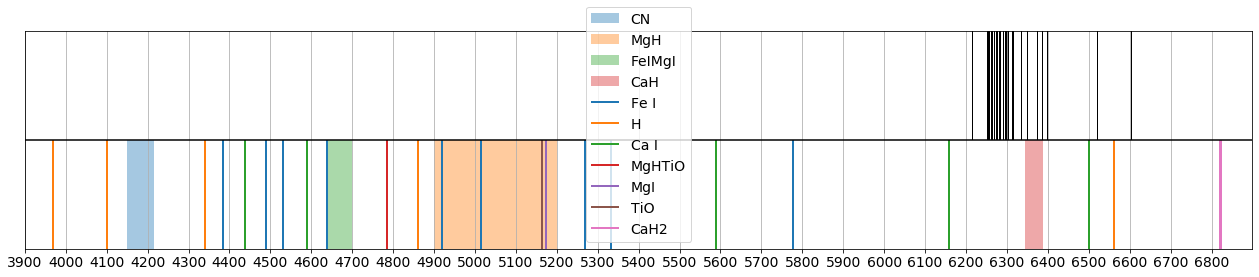

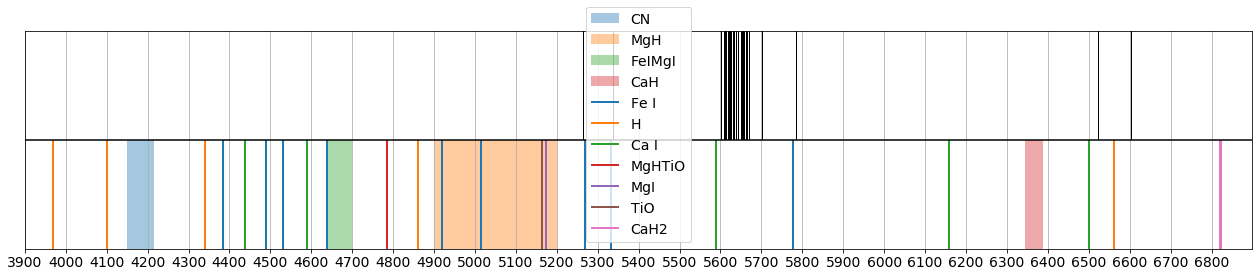

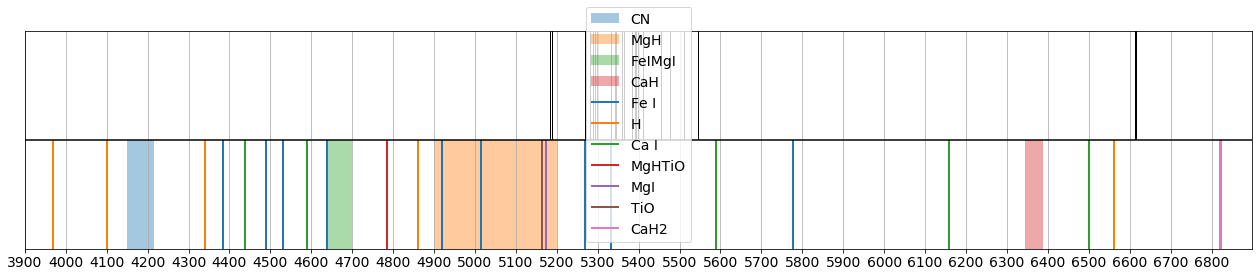

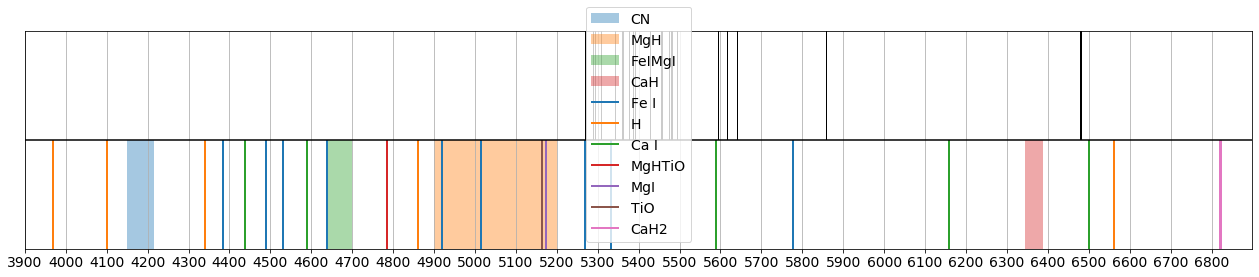

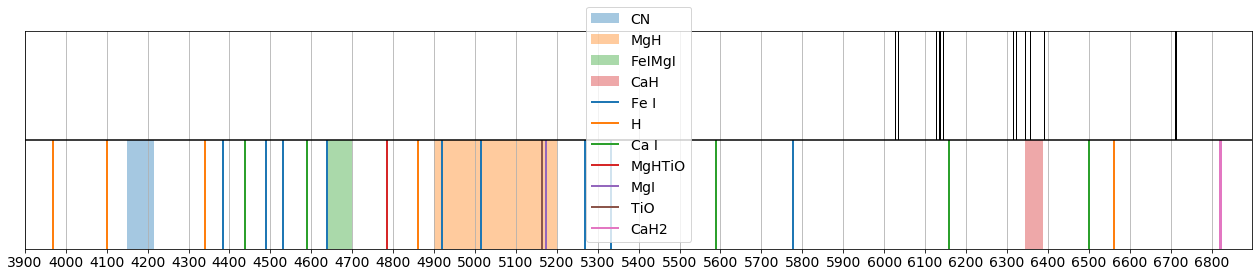

In [518]:
for key in sline_dict100.keys():
    get_slines_hist(key, sline_dict100, linedict_logg, linedict_logg2, ub = 6900, lb = 3900, step = 100)

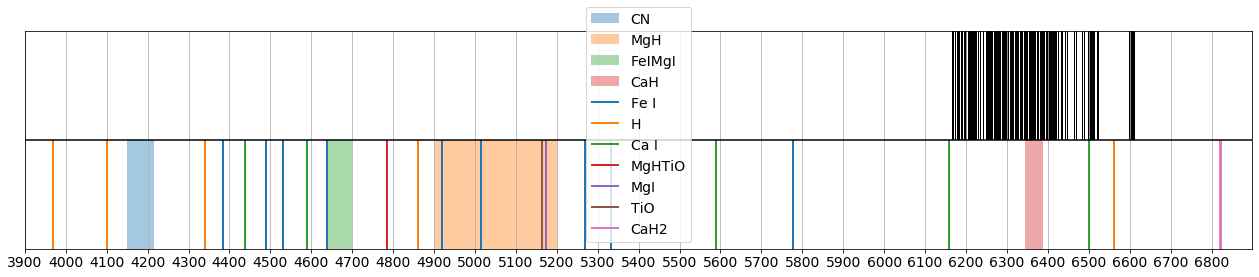

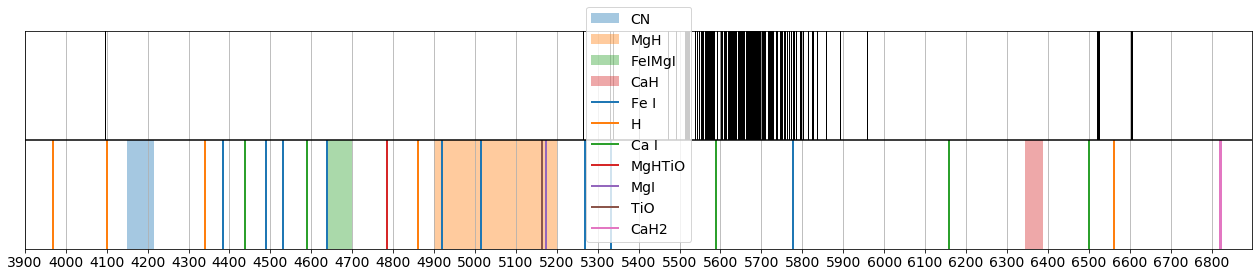

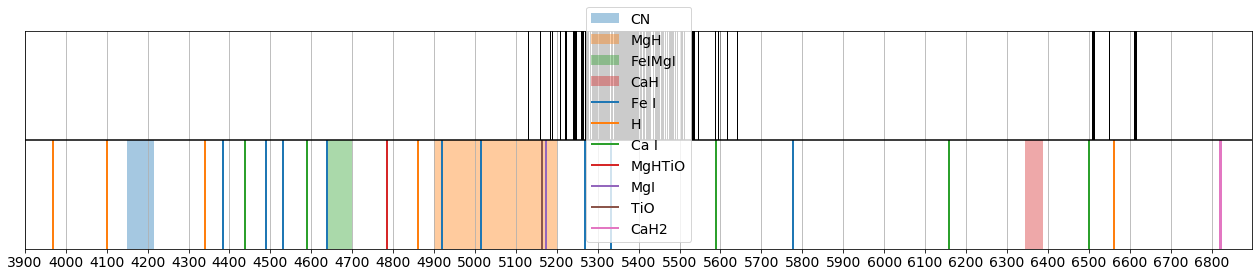

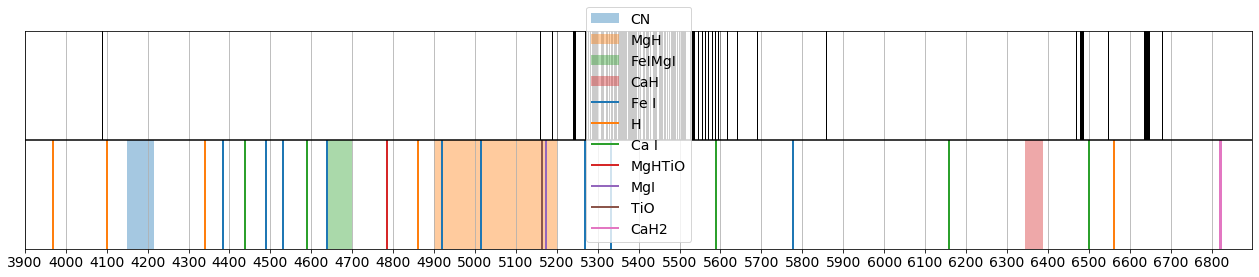

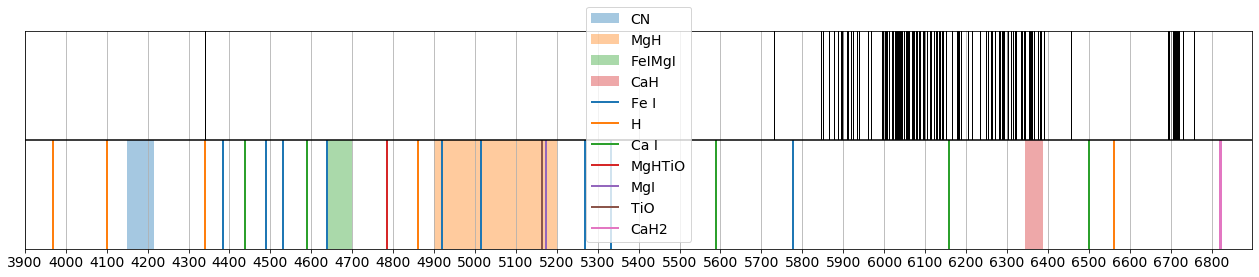

In [519]:
for key in sline_dict100.keys():
    get_slines_hist(key, sline_dict500, linedict_logg, linedict_logg2, ub = 6900, lb = 3900, step = 100)

In [70]:
wv_rg = (390 * u.nm, 500 * u.nm)

In [74]:
ll0 = Atm.query_object(wv_rg, wavelength_type='Vacuum', wavelength_accuracy=20, element_spectrum = "Mg", output_columns = ('spec',"type","prob","ener"))
ll0 = get_high_aki(ll0, '0')
# helist = ll0["LAMBDA VAC ANG"]
ll0

,LAMBDA VAC ANG,SPECTRUM,TT,A_ki,LEVEL ENERGY CM 1,TF
0,3900.,Mg VIII,E1,1.41E+07,1383760.00 - 1409400.00,1
4,3939.5150,Mg I,E1,5.46E+06,35051.26 - 60435.10,1
6,3948.00,Mg IV,E1,8.19E+04,582562.40 - 607891.70,1
7,3950.49,Mg IV,E1,5.84E+03,582578.40 - 607891.70,1
11,3985.339,Mg I,E1,9.94E+04,35051.26 - 60143.23,1
...,...,...,...,...,...,...
258,4931.,Mg VII,E1,3.59E+05,1191750.00 - 1212030.00,1
263,4940.082,Mg II,E1,1.11E+03,92790.51 - 113033.09,1
264,4940.775,Mg II,E1,1.11E+03,92790.51 - 113030.25,1
268,4957.9,Mg V,E1,7.83E+05,941944.00 - 962114.00,1


In [395]:
ll0_h = None
wv0 = 400
ub = 950
typewv = "AIR"
while ub - wv0 > 2:
    wv_rg = (wv0 * u.nm, ub * u.nm)
    ll0 = Atm.query_object(wv_rg, wavelength_type='air', wavelength_accuracy=20, nmax=3, transitions = T.E1, output_columns = ('spec',"type","prob"))
    ll0_h = pd.concat([ll0_h, get_high_aki(ll0)], ignore_index = True)
    lval = ll0[f'LAMBDA {typewv} ANG'][-1]
    try:
        wv0 = int(lval[:3])
    except:
        wv0 = lval/10
        print(lval)
    print(wv0)
print(ll0_h)


499
686
949
   LAMBDA AIR ANG SPECTRUM  TT      A_ki  TF
0         4057.75     N IV  E1  6.62E+07   1
1       4078.8424     O II  E1  5.56E+07   1
2        4081.020    O III  E1  6.02E+07   1
3       4097.2249     O II  E1  6.42E+07   1
4         4097.35    N III  E1  8.66E+07   1
..            ...      ...  ..       ...  ..
93       6103.538     Li I  E1  5.74E+07   1
94       6103.649     Li I  E1  6.89E+07   1
95        6610.56     N II  E1  6.32E+07   1
96     6678.15166     He I  E1  6.38E+07   1
97       8194.824     Na I  E1  5.29E+07   1

[98 rows x 5 columns]


In [693]:
def get_element_lines(el_str, ub = 950, lb = 400):
    wv_rg = (lb * u.nm, ub * u.nm)
    pdE = Atm.query_object(wv_rg, wavelength_type='vacuum', wavelength_accuracy=20, element_spectrum=el_str, output_columns = ('spec',"prob"))
    lines = pdE[pdE['A_ki'] > 10e4]["LAMBDA VAC ANG"]
    print(lines)
    return lines
    # pdE = pdE.to_pandas()
def get_sline_plot(sline_wv100, linedict, lb=3800,ub=700):
    plt.figure(figsize=(22,4))
    colorlist = ["y","r","g", "lightblue", 'cyan','m','salmon']
    for idx, (key, vals) in enumerate(linedict.items()):
        c = colorlist[idx]
        plt.vlines(vals, 0,1, color = c, label = key)
    plt.stem(sline_wv100, np.ones(len(sline_wv100))*0.5, linefmt = 'gray', )
    plt.ylim(0,1)
    plt.xlim(lb,ub)
    plt.legend()

In [303]:
ll0 = Atm.query_object(wavelength_range0, wavelength_type='Vacuum', wavelength_accuracy=20, nmax=3, transitions = T.E1, output_columns = ('spec',"type","prob"))
def get_high_aki(ll0):
    ll0 = ll0.to_pandas()
    ll0["TF"] = 0
    for idx, aki in enumerate (ll0['A_ki']):
        last1,last0 = aki[-2], aki[-1]
        if (last1 >= '1' and last1 <= '9'):
            ll0["TF"][idx] = 1
        elif (last0 >= '8' and last0 <= '9'):
            ll0["TF"][idx] = 1
    result = ll0[ll0["TF"] == 1]
    print(result)
    return result

In [ ]:
rel_grad = np.divide(grad0_1d, fluxH1D)
rel_grad[np.isnan(rel_grad)] = 0

In [ ]:
fig, axs = plt.subplots(2,5, figsize = (22,8), sharey = True, sharex = True)
i = 0
for ax in axs.flatten():
    c_1dd = c_dif1d[i]
    c_dif1dlog = np.log10(c_1dd[c_1dd>0])
    ax.hist(c_dif1dlog,log = True, bins = 100, label =f"{para_str}: {lgparas[i]}~ {lgparas[i+1]}" )
    ax.legend(loc = 1)
#     ax.set_ylim([0,1])
    ax.set_xlim([-5,0])
    i +=1
fig.suptitle("Simplex Interpolation of Log(g) at T = 4000K, [Fe/H] = 0 ")

In [ ]:
rcParams['figure.figsize'] = 5

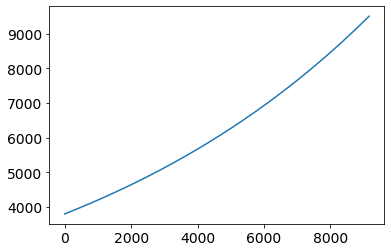

In [710]:
plt.plot(grid_wv)

#### We pick the absolute laplacian since it matches the dimension.

In [193]:
def get_maxsum_1d(grad1d, para0, grid_wv,  d = 200, ax = None, norm = LogNorm()):
    grad1d = abs(grad1d)
    para0 = np.insert(para0[1:-1], 0,para0[1]) 
    if ax is None:
        ax = plt.gca()
    maxsum = np.zeros((len(grad1d),1))
    l_grad1d = len(grad1d[0])//d+2
    while len(grad1d[0])> 0:
        grads = grad1d[:,:d]
        grads = np.max(grads, axis = 1)
        maxsum = np.hstack((maxsum,grads[:,None]))
        grad1d = grad1d[:,d:]
    print(maxsum.shape) 
    cax = ax.matshow(maxsum[:,1:], origin = "lower", norm = norm)
    para1 = np.int(np.linspace(grid_wv[0], grid_wv[-1], l_grad1d))
    #     cax = ax.matshow(maxsum, interpolation='nearest', origin = "lower")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_yticklabels(para0)
    ax.set_xticklabels(para1)
    plt.setp(ax.get_xticklabels(), rotation=45)
#     ax.set_xticks(rotation=45)
#     ax.set_title(f'maxinum gradient per {d} wavelength vs parameter interpolated ')
    return maxsum, cax


### maxinum gradient per {d} wavelength vs parameter interpolated

(5, 47)


TypeError: only size-1 arrays can be converted to Python scalars

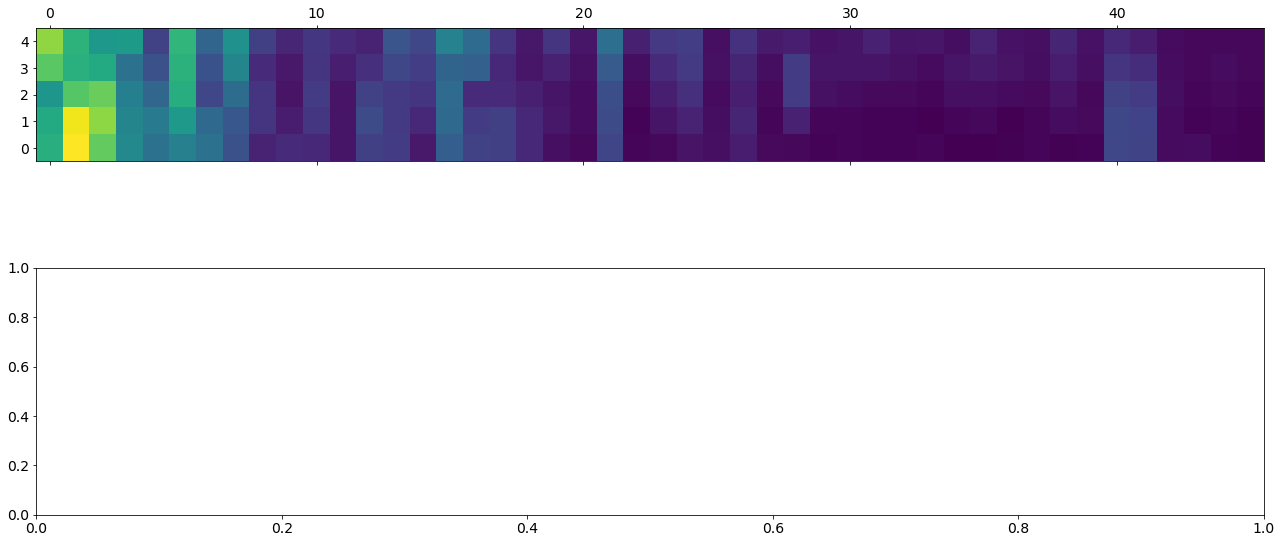

In [194]:
fig, (ax0,ax1) = plt.subplots(2, 1, figsize = (22,10))
maxsum, cax = get_maxsum_1d(laplace_frac, lg_paras, grid_wv, d = 200, ax = ax0, norm = None )
maxsum = get_maxsum_1d(laplace_frac, lg_paras,grid_wv, d = 200, ax = ax1, norm = LogNorm() )

fig.colorbar(cax, orientation="horizontal")

In [785]:
laplace_frac.shape

(5, 9162)

In [807]:
def plot_grad_metrics(mats, paras, para_str):
    fig, axs = plt.subplots(1, len(mats), figsize = (22,5), sharey=True)
    mat_idx = 0
    labels = ["median", "max", "95%"]
    label0s = ["Relative Laplace","Laplace"]
    for ax in axs.flatten():
        mat = mats[mat_idx]
        x = [np.median(mat,axis = 1),np.max(mat,axis = 1),np.quantile(mat,0.95, axis = 1)]
        for i in range(3):
            x[i] = x[i]/np.linalg.norm(x[i])
            ax.plot(paras, x[i], label = labels[i])
        ax.set_title(f'Norm pdf via 3 contractions of $\lambda$ of {label0s[mat_idx]}')
        ax.set_xlabel(f"{para_str}")
        ax.legend(loc = 4)
        mat_idx +=1        
        

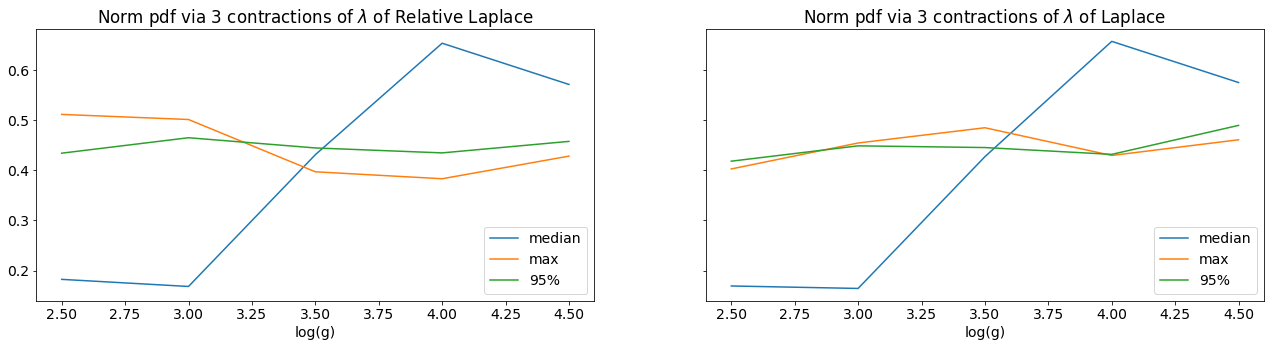

In [808]:
plot_grad_metrics( [laplace_frac_abs, abs(laplace_1d) ], lg_paras0, "log(g)")

# As a result, we peak 95% quantile value to be the contraction method since it characterize the gradient the most.
##### test how well we can interpolate in the grid.

#### I.III Plotting 1D Gradient

In [850]:
def get_laplace_1d(fluxH1D, maskH1D):
    fluxH1D[~maskH1D] = nan
    if len(fluxH1D.shape) ==1:
        fluxH1D = fluxH1D[:,None]
    head, mid, tail = fluxH1D[:-2,:], fluxH1D[1:-1,:], fluxH1D[2:,:]
    laplace = (head + tail - 2 * mid)/2
    laplace = abs(np.divide(laplace, fluxH1D[1:-1,:]))
    laplace[np.isnan(laplace)] = 0  
    laplace = np.quantile(laplace, 0.95, axis = 1)
    return laplace

def get_grad_1d(para_str, fluxH1D):
    paras, dx = get_params_dx(para_str)
    fluxH1D[~maskH1D] = nan
    grad = np.abs(np.gradient(fluxH1D, dx,axis = 0))    
    if len(grad.shape) ==2:
        grad = np.quantile(grad, 0.95, axis = 1)
    print(grad[:10] )  
    grad[np.isnan(grad)] = 0
    return grad, paras
def plot_grad_1d(grad1d, paras, grid = grid, title = None, ax = plt):
    norm_grad1d = grad1d / np.linalg.norm(grad1d)
#     paras = grid.params[para_str].values 
    ax.plot(paras, norm_grad1d) 
    ax.set_xticks(paras )
#     ax.set_xlabel(para_str)
    ax.set_title(title)
    ax.set_ylim([0,1])

def plot_grads_1d(grads, labels, paras, grid = grid, title = None, ax = plt):
#     paras = grid.params[para_str].values 
    i = 0
    for grad1d in grads:
#         norm_grad1d = grad1d / np.linalg.norm(grad1d)
        ax.scatter(paras, grad1d, label = f"{labels[i]}") 
        i += 1
    ax.set_xticks(paras )
#     ax.set_xlabel(para_str)
    ax.set_title(title)
#     ax.set_ylim([0,1])
    ax.legend()

In [839]:
para_str = "log_g"
laplace_1d = get_laplace_1d(fluxH1D, maskH1D)
idxH = np.argsort(abs(grid_wv - halpha))[0]
laplace_1dH = get_laplace_1d(fluxH1D[:,idxH], maskH1D)


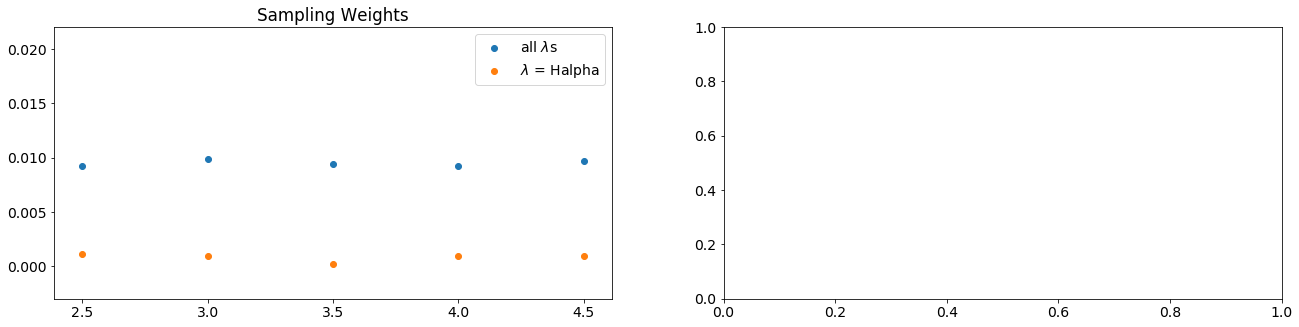

In [841]:
fig, (ax0,ax1) = plt.subplots(1,2 , figsize = (22,5))
plot_grads_1d([laplace_1d,laplace_1dH], ["all $\lambda$s", "$\lambda$ = Halpha"], lg_paras0, title = f"Sampling Weights", ax = ax0)

#### I.IV 1D Sampling

In [842]:
from numpy.random import randint
from random import choices

In [851]:
def grid_sampling_1d(grad, k =10):
    return choices(np.arange(len(grad)), grad, k = k) 

def plot_grid_sampling_1d(grad, paras, k = 100):
    l_grad = len(grad)
    grid_samples_1d = grid_sampling_1d(grad, k = k)  
    fig, (ax0,ax1) = plt.subplots(1,2, figsize =(20,5))
    plot_grad_1d(grad, paras, title = "Sampling Weights for all $\lambda$s", ax = ax0)  
#     sns.distplot(grid_samples_1d, bins = l_grad, kde_kws={"clip":(0,l_grad)}, hist_kws={"range":(0,l_grad)})    
    hist,bin_edges = np.histogram(grid_samples_1d, bins = l_grad, range = [0,l_grad], density = True )
    ax1.bar(paras, hist, width = 0.25, color='#0504aa',alpha=0.7)  
    ax1.set_title(f'Histogram of {k} samples')
#     ax1.set_xlabel(f"{para_str}")
    ax1.grid(True)
    return grid_samples_1d


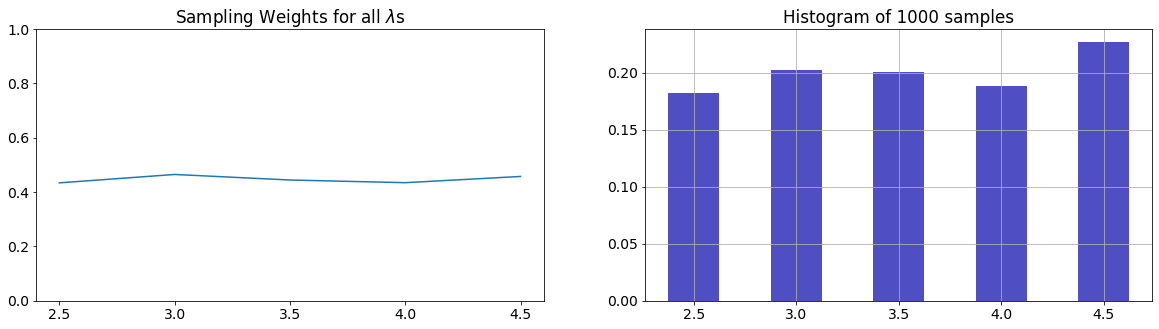

In [852]:
grid_samples_1d = plot_grid_sampling_1d(laplace_1d, lg_paras0, k = 1000)

### II. 2D case 
#### II.I 2D Grid & Mask  
    - fixing 2 out of 3 at [Fe/H] = -2.0,  Teff = 5000, log(g) = 5 

In [863]:
idx_Teff1 =np.where(Te_paras ==5000)[0][0]
idx_log =np.where(lg_paras == 3.5 )[0][0]
idx_FeH =np.where(Fe_paras == -2.0 )[0][0]
idx_Teff1, idx_log,idx_FeH

(6, 3, 2)

In [864]:
flux3.shape

(14, 26, 7, 9162)

In [865]:
fluxFeLg = copy.deepcopy(flux3[:,idx_Teff1,:])
fluxFeTe = copy.deepcopy(flux3[:,:,idx_log])
fluxTeLg = copy.deepcopy(flux3[idx_FeH,:,:])
fluxFeLg.shape, fluxFeTe.shape, fluxTeLg.shape

((14, 7, 9162), (14, 26, 9162), (26, 7, 9162))

###### masks

In [866]:
maskFeLg = flux3_mask[:,idx_Teff1,:]

#### II.II 2D Gradient

In [ ]:
def get_simplex_2d(fluxH2D, mask2D, dx, dy, dim = 2):
    

In [ ]:
def get_laplace_1d(fluxH1D, maskH1D):
    fluxH1D[~maskH1D] = nan
    if len(fluxH1D.shape) ==1:
        fluxH1D = fluxH1D[:,None]
    head, mid, tail = fluxH1D[:-2,:], fluxH1D[1:-1,:], fluxH1D[2:,:]
    laplace = (head + tail - 2 * mid)/2
    laplace = abs(np.divide(laplace, fluxH1D[1:-1,:]))
    laplace[np.isnan(laplace)] = 0  
    laplace = np.quantile(laplace, 0.95, axis = 1)
    return laplace

In [874]:
def get_laplace_2d(fluxH2D, mask2D):
    d = len(fluxH2D.shape)
    fluxH2D[~mask2D] = nan
    if d == 2:
        fluxH2D = fluxH2D[:,None]
    t,b, mid, l,r = fluxH2D[:-2, 1:-1,:], fluxH2D[2:,1:-1,:], fluxH2D[1:-1,1:-1, :], fluxH2D[1:-1,:-2, :], fluxH2D[1:-1,2:, :],
    laplace = (t+b+l+r - 4 * mid)/4
    laplace = abs(np.divide(laplace, fluxH2D[1:-1,1:-1,:]))
    laplace[np.isnan(laplace)] = 0  
    laplace95 = np.quantile(laplace, 0.95, axis = -1)
    print(np.shape(laplace), np.shape(laplace95))

    return laplace, laplace95

In [898]:
def get_laplace_2d1(fluxH2D, mask2D):
    d = len(fluxH2D.shape)
    fluxH2D[~mask2D] = nan
    if d == 2:
        fluxH2D = fluxH2D[:,None]
    t,b, mid, l,r = fluxH2D[:-2, 1:-1,:], fluxH2D[2:,1:-1,:], fluxH2D[1:-1,1:-1, :], fluxH2D[1:-1,:-2, :], fluxH2D[1:-1,2:, :],
    laplacetb = (t+b - 2 * mid)/2
    laplacelr = (l+r - 2 * mid)/2
    latb = abs(np.divide(laplacetb, fluxH2D[1:-1,1:-1,:]))
    latb[np.isnan(latb)] = 0  
    latb95 = np.quantile(latb, 0.95, axis = -1)
    print(np.shape(latb), np.shape(latb95))
    lalr = abs(np.divide(laplacelr, fluxH2D[1:-1,1:-1,:]))
    lalr[np.isnan(lalr)] = 0  
    lalr95 = np.quantile(lalr, 0.95, axis = -1)
    print(np.shape(lalr), np.shape(lalr95))

    return latb,latb95, lalr, lalr95

In [875]:
laplace_2d, laplace_2d95 = get_laplace_2d(fluxFeLg, maskFeLg)

(12, 5, 9162) (12, 5)


In [918]:
laplace_2d95.max(), lalr95.min(), lalr.min()

(0.008044821235121038, 0.001973037105008042, 0.0)

In [899]:
latb,latb95, lalr, lalr95 = get_laplace_2d1(fluxFeLg, maskFeLg)

(12, 5, 9162) (12, 5)
(12, 5, 9162) (12, 5)


In [923]:
def plot_laplace_2d(grad2d, para0, para1, ax = plt):
    para0 = np.insert(para0, 0,para0[0])    
    para1 = np.insert(para1, 0,para1[0])    
    cax = ax.matshow(grad2d, interpolation='nearest', origin = "lower", vmin=0, vmax=0.03)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_yticklabels(para0)
    ax.set_xticklabels(para1)

In [892]:
Fe_paras0 = Fe_paras[1:-1]

Text(0.5, 0.98, '2D relative Laplacian $\\Delta f/ f $ of [Fe/H] and log(g)')

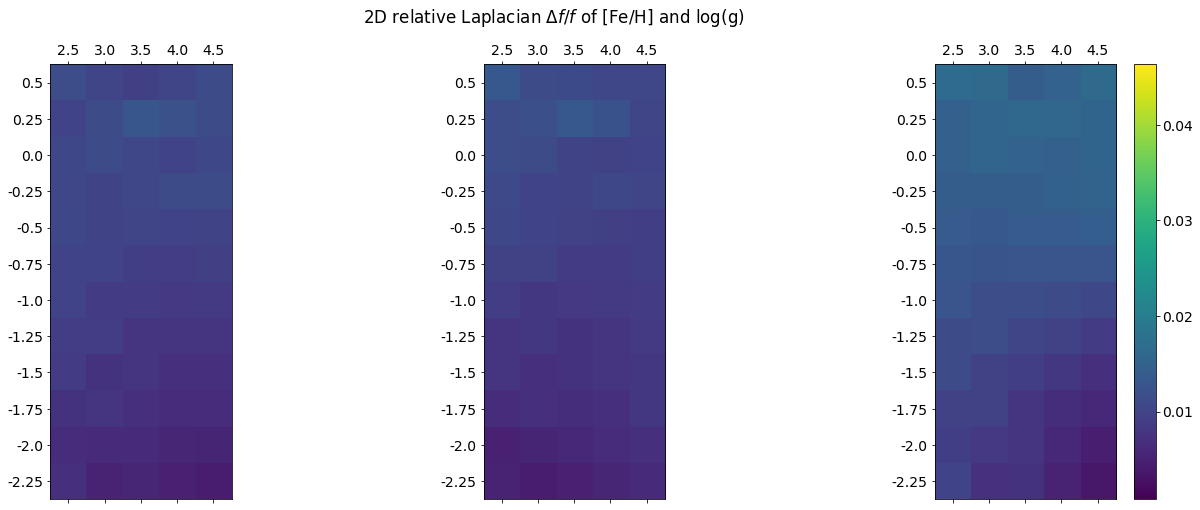

In [924]:
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize = (22,8))
# ax = fig.add_subplot(111)
para1, para0 = lg_paras0, Fe_paras0,
plot_laplace_2d(laplace_2d95, para0, para1, ax = ax0)
plot_laplace_2d(latb95, para0, para1, ax = ax1)
plot_laplace_2d(lalr95, para0, para1,ax = ax2)

fig.colorbar(cax)
fig.suptitle("2D relative Laplacian $\Delta f/ f $ of [Fe/H] and log(g)")

#### 2D Sampling

In [ ]:
grad2d

In [1420]:
def grid_sampling_2d(grad, k =10):
    grad_1d = np.reshape(grad,(-1))
    mat = np.arange(len(grad_1d))
    samples_1d = choices(mat, grad_1d, k = k) 
    mat = np.reshape(mat, np.shape(grad))
    samples_2d =np.array([np.array(np.where(mat == samples_1d[i])).flatten() for i in range(k)] )
    return samples_2d
from matplotlib.colors import LogNorm
def plot_grid_sampling_2d(grad, k = 100):
    (d1, d2)  = grad.shape
    samples_2d = grid_sampling_2d(grad, k = k)  
    fig, (ax0,ax1) = plt.subplots(1,2, figsize =(20,10))
    plot_grad_2d(grad2d, ax = ax0)
    _ = ax1.hist2d(samples_2d[:,1],samples_2d[:,0], bins = 50, range = [[0,d2], [0,d1]])  
    ax1.set_title(f'Histogram of {k} samples')
    ax1.grid(True)
    return samples_2d

In [1447]:
samples_2d

array([[11, 10],
       [ 0,  5],
       [13,  8],
       ...,
       [ 4,  2],
       [10,  7],
       [13,  9]])

In [1445]:
df = pd.DataFrame(samples_2d, columns = ["x","y"])

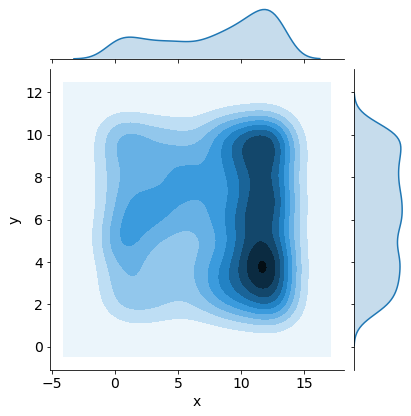

In [1449]:
sns.jointplot(x="x", y="y", data=df, kind="kde", )

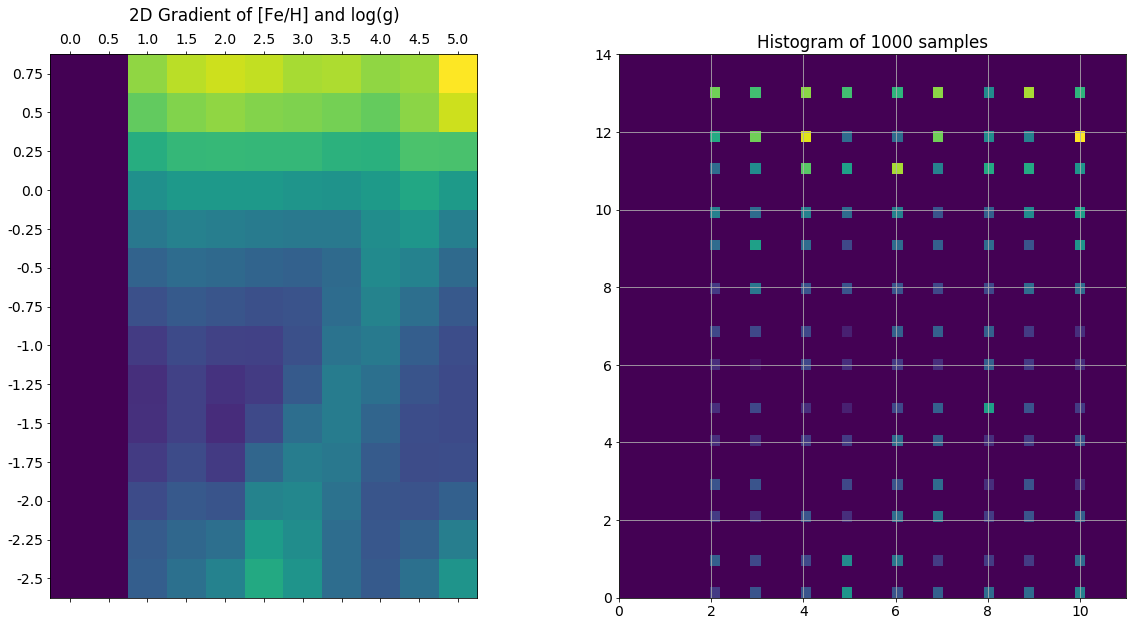

In [1421]:
samples_2d = plot_grid_sampling_2d(grad2d, k = 1000)

- do we want to sample more around edges and holes?4

### Grid parameters

In [30]:
grid.params

{'Fe_H': <pfsspec.data.gridparam.GridParam at 0x7f63c8ed8eb8>,
 'T_eff': <pfsspec.data.gridparam.GridParam at 0x7f63c8ed8860>,
 'log_g': <pfsspec.data.gridparam.GridParam at 0x7f63c8ed8898>,
 'C_M': <pfsspec.data.gridparam.GridParam at 0x7f63c8ed8828>,
 'O_M': <pfsspec.data.gridparam.GridParam at 0x7f63c8ed88d0>}

# Plot some nice spectra for Xprize

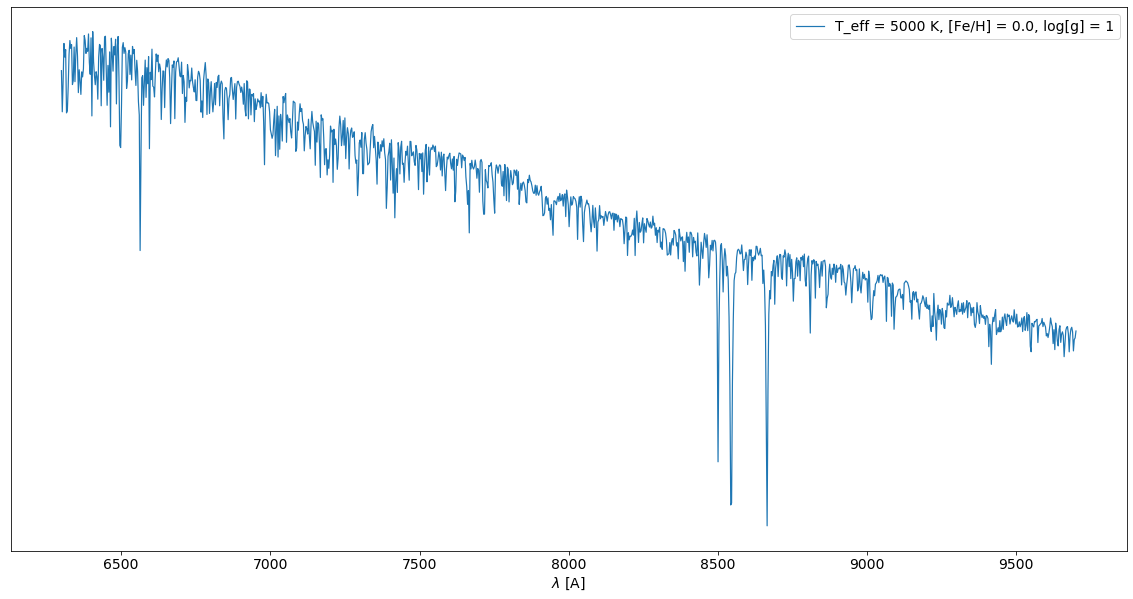

In [39]:
wave = np.linspace(6300, 9700, 1200)
spec = grid.get_nearest_model(Fe_H=0.0, T_eff=5000, log_g=1, C_M=0, O_M=0)
spec.rebin(wave)
plt.figure(figsize=(20,10))
plt.plot(spec.wave, spec.flux, '-', lw=1.2, label='T_eff = 5000 K, [Fe/H] = 0.0, log[g] = 1')
# plt.plot(spec.wave, spec.cont, '-', lw=0.3)
plt.yticks([])
plt.legend()
plt.xlabel('$\lambda$ [A]')

    
plt.savefig('spectra1.svg', transparent=True)

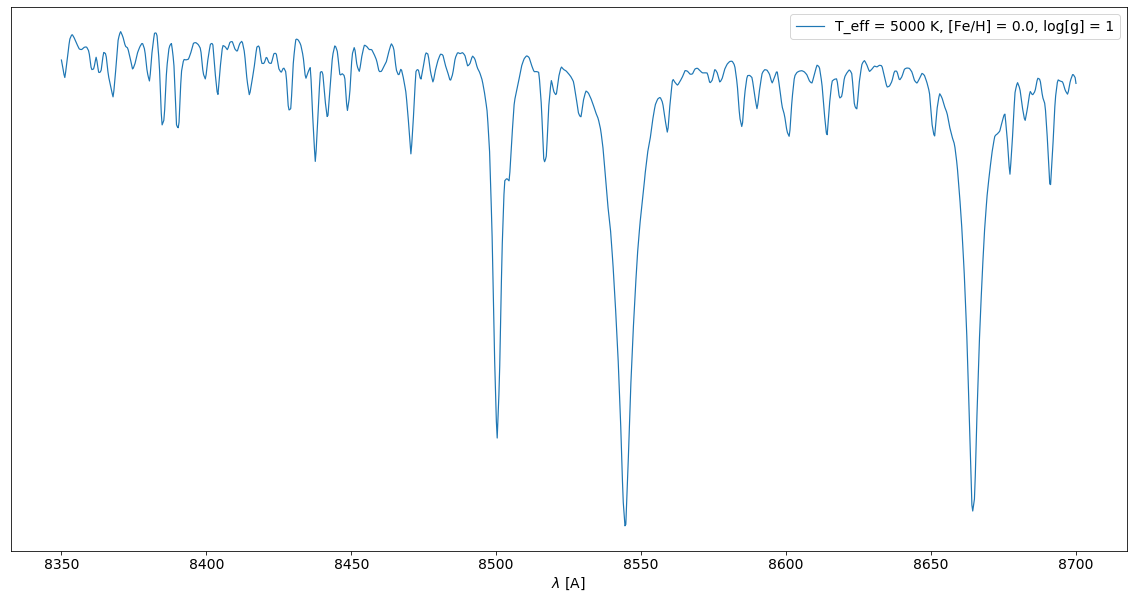

In [41]:
wave = np.linspace(8350, 8700, 1200)
spec = grid.get_nearest_model(Fe_H=0.0, T_eff=5000, log_g=1, C_M=0, O_M=0)
spec.rebin(wave)
plt.figure(figsize=(20,10))
plt.plot(spec.wave, spec.flux, '-', lw=1.2, label='T_eff = 5000 K, [Fe/H] = 0.0, log[g] = 1')
# plt.plot(spec.wave, spec.cont, '-', lw=0.3)
plt.yticks([])
plt.legend()
plt.xlabel('$\lambda$ [A]')

    
plt.savefig('spectra-zoom.svg', transparent=True)

# Plot some nice spectra

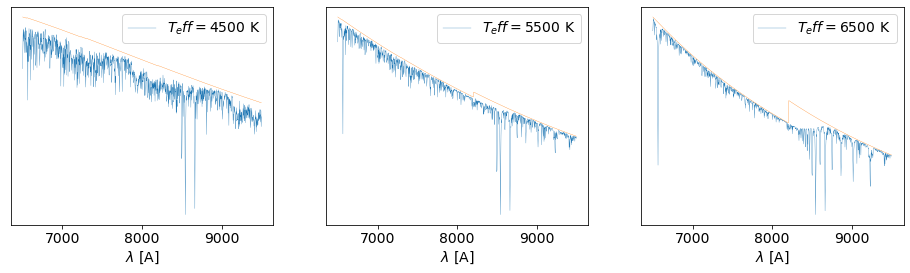

In [15]:
wave = np.linspace(6500, 9500, 1200)
T_eff = [4500, 5500, 6500]


f, axs = subplots(1, 3, figsize=(16, 4), squeeze=False)

i = 0
for t in T_eff:
    spec = grid.get_nearest_model(Fe_H=0.0, T_eff=t, log_g=1, C_M=0, O_M=0)
    spec.rebin(wave)
    axs[0, i].plot(spec.wave, spec.flux, '-', lw=0.3, label=r'$T_eff = {}$ K'.format(t))
    axs[0, i].plot(spec.wave, spec.cont, '-', lw=0.3)
    axs[0, i].set_yticks([])
    axs[0, i].legend()
    axs[0, i].set_xlabel('$\lambda$ [A]')
    i += 1
    
f.savefig('temperature.svg', transparent=True)

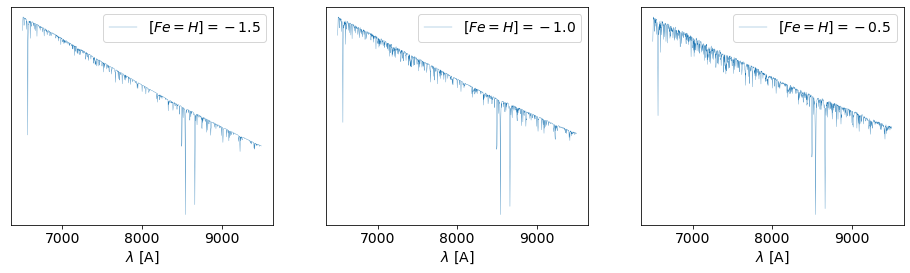

In [16]:
wave = np.linspace(6500, 9500, 1200)
Fe_H = [-1.5, -1.0, -0.5]


f, axs = subplots(1, 3, figsize=(16, 4), squeeze=False)

i = 0
for feh in Fe_H:
    spec = grid.get_nearest_model(Fe_H=feh, T_eff=5000, log_g=1, C_M=0, O_M=0)
    spec.rebin(wave)
    axs[0, i].plot(spec.wave, spec.flux, '-', lw=0.3, label=r'$[Fe=H] = {}$'.format(feh))
    axs[0, i].set_yticks([])
    axs[0, i].legend()
    axs[0, i].set_xlabel('$\lambda$ [A]')
    i += 1
    
f.savefig('metallicity.svg', transparent=True)

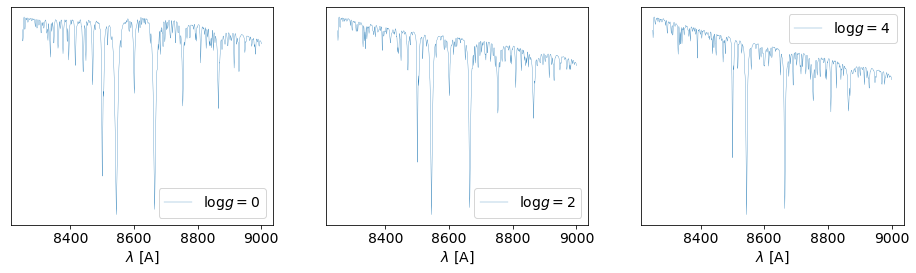

In [48]:
wave = np.linspace(8250, 9000, 1000)
log_g = [0, 2, 4]


f, axs = subplots(1, 3, figsize=(16, 4), squeeze=False)

i = 0
for g in log_g:
    spec = grid.get_nearest_model(Fe_H=0.0, T_eff=6000, log_g=g, C_M=0, O_M=0)
    spec.rebin(wave)
    axs[0, i].plot(spec.wave, spec.flux, '-', lw=0.3, label=r'$\log g = {}$'.format(g))
    axs[0, i].set_yticks([])
    axs[0, i].legend()
    axs[0, i].set_xlabel('$\lambda$ [A]')
    i += 1
    
f.savefig('gravity.svg', transparent=True)

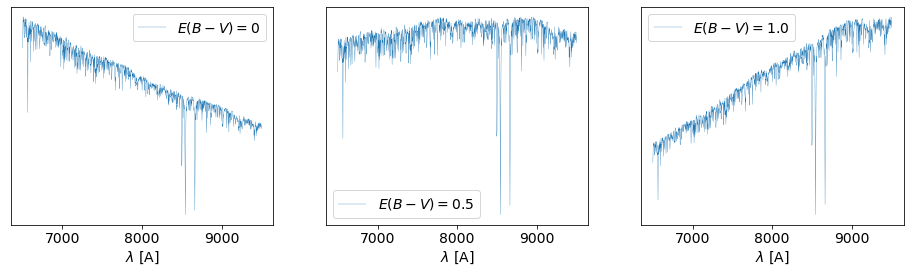

In [49]:
wave = np.linspace(6500, 9500, 1200)
ext = [0, 0.5, 1.0]


f, axs = subplots(1, 3, figsize=(16, 4), squeeze=False)

i = 0
for e in ext:
    spec = grid.get_nearest_model(Fe_H=0.0, T_eff=5000, log_g=1, C_M=0, O_M=0)
    spec.redden(e)
    spec.rebin(wave)
    axs[0, i].plot(spec.wave, spec.flux, '-', lw=0.3, label=r'$E(B-V) = {}$'.format(e))
    axs[0, i].set_yticks([])
    axs[0, i].legend()
    axs[0, i].set_xlabel('$\lambda$ [A]')
    i += 1
    
f.savefig('extinction.svg', transparent=True)

# Plot a few examples

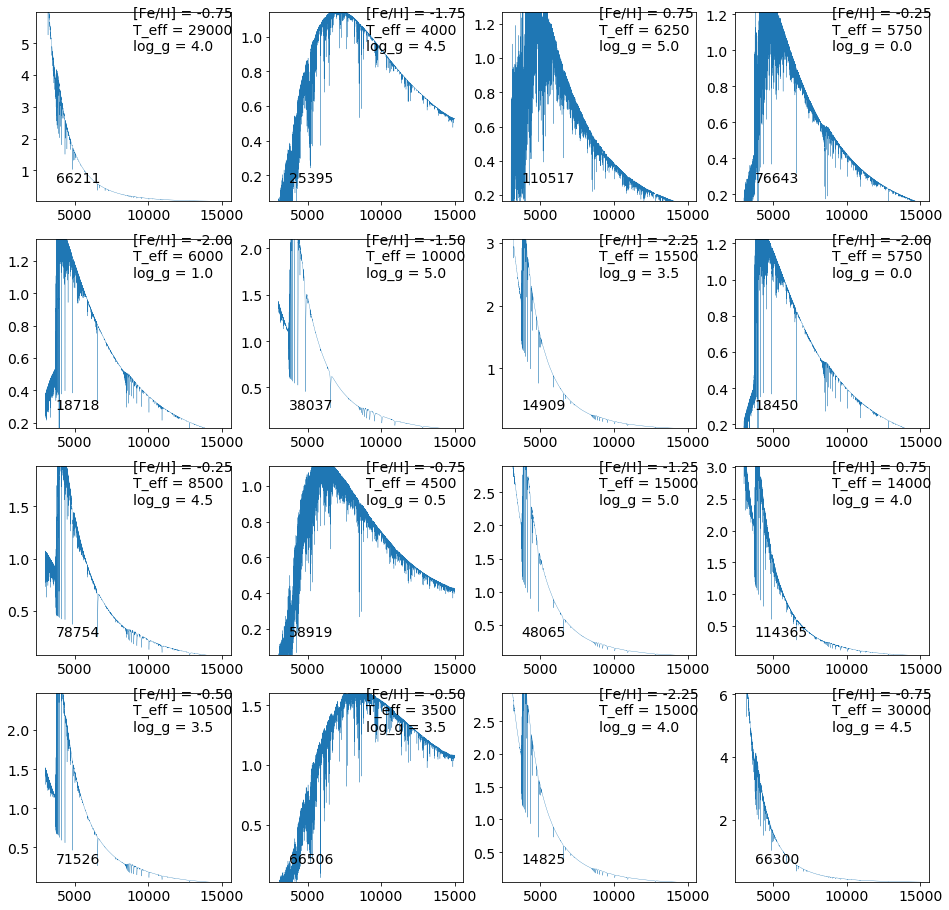

In [17]:
f, axs = plt.subplots(4, 4, figsize=(16, 16))

i = 0
ff = grid.flux[grid.flux_idx]
pi = np.where(grid.flux_idx)
id = np.random.randint(ff.shape[0], size=axs.size)
#id = 64
for ax in axs.flatten():
    idx = np.digitize([4000, 8000], grid.wave)
    mm = np.median(ff[id[i], idx[0]:idx[1]])
    #ax.plot([4000, 12000], [mm, mm])
    
    ax.plot(grid.wave, ff[id[i], :] / mm, lw=0.3)
    mm = np.quantile(ff[id[i], :] / mm, [0.05, 0.95])
    ax.set_ylim(mm[0], mm[1])
    #mm = np.median(ds.flux[id + i, :])
    #ax.set_ylim(-2 * mm, 10 * mm)
    #ax.set_ylim(-1, 3)
    ax.text(0.1, 0.1, str(id[i]), transform=ax.transAxes)
    ax.text(0.5, 0.8, \
"""[Fe/H] = %.2f
T_eff = %.0f
log_g = %.1f""" % (grid.params['Fe_H'].values[pi[0][id[i]]],
                 grid.params['T_eff'].values[pi[1][id[i]]],
                 grid.params['log_g'].values[pi[2][id[i]]]), transform=ax.transAxes)
    i += 1
    
#plt.savefig(os.path.join(DATASET_PATH, 'examples.png'))

# Try to fit the continuum

The Cannon:

"To initialize the continuum-pixel determination, we define a
preliminary pseudo-continuum-normalization by using polynomial
fit to an upper quantile (for example, 80% or 90%) of
the spectra, determined, for example, from a running median.
For this pseudo continuum-normalized APOGEE spectra we
use a running quantile across 50 Å of the spectra, taking the
90th percentile. This is effective, but S/N-dependent."


The Cannon's approach will likely not work at short wavelength due to strong line blanketing. Can we still normalize somehow in this range in a way that's S/N independent?

At low temperatures, we only have a little bit of hope to correctly normalize the spectrum in the 12000 A range because of strong absorption features elsewhere.

In [18]:
from pfsspec.obsmod.spectrum import Spectrum
from pfsspec.obsmod.noise import Noise
from pfsspec.obsmod.filter import Filter

In [20]:
spec = grid.get_nearest_model(Fe_H=0.0, T_eff=3800, log_g=3, C_M=0, O_M=0)

[]

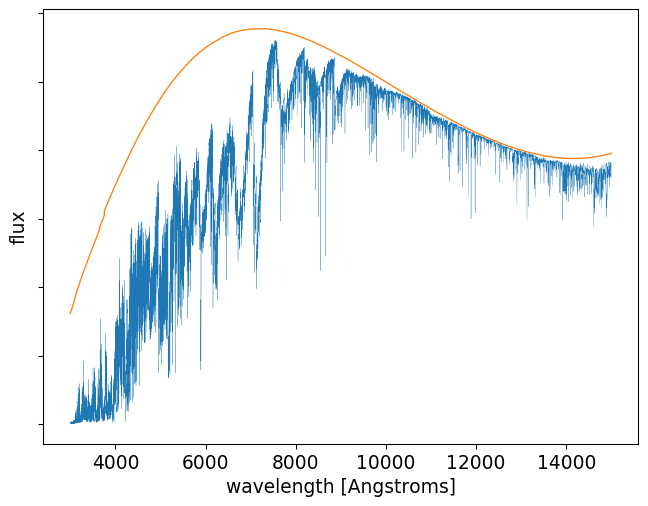

In [21]:
f, axs = subplots(1, 1, figsize=(8, 6), facecolor='white', dpi=96, squeeze=False)
ax = axs[0, 0]
ax.plot(spec.wave, spec.flux, lw=0.2)
ax.plot(spec.wave, spec.cont, lw=1)

ax.set_xlabel('wavelength [Angstroms]')
ax.set_ylabel('flux')

ax.yaxis.set_ticklabels([])

#ax.set_xlim(8000, 9000)

In [22]:
filt = Filter()
filt.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/hsc/hsc_r.dat'))

In [23]:
spec.normalize_to_mag(filt, 20)

In [24]:
#nwave = np.arange(3800, 6500, 2.7)
nwave = np.arange(6300, 9700, 2.7)
#nwave = np.arange(9400, 12600, 2.7)
spec.rebin(nwave)

In [25]:
noise = Noise()
noise.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/pfs/noise/sim8hr.dat'))
noise.resample(spec.wave)
noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)

In [26]:
dl = (200, 200)

cont = Spectrum.running_filter(spec.wave, spec.flux, np.median, dlambda=dl)
ncnt = Spectrum.running_filter(spec.wave, noiz, np.median, dlambda=dl)

#cont = Spectrum.running_filter(spec.wave, spec.flux, lambda y: np.quantile(y, 0.95), dlambda=dl)
#ncnt = Spectrum.running_filter(spec.wave, noiz, lambda y: np.quantile(y, 0.95), dlambda=dl)


cont_var = Spectrum.running_filter(spec.wave, cont, np.var, dlambda=dl)
ncnt_var = Spectrum.running_filter(spec.wave, ncnt, np.var, dlambda=dl)

(8000, 9000)

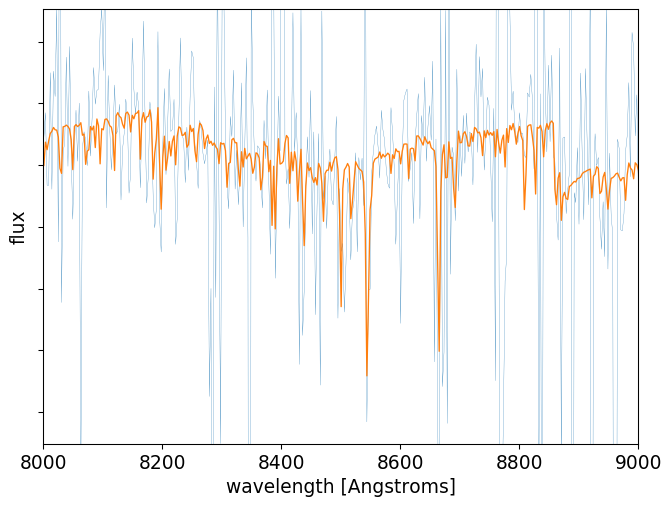

In [27]:
f, axs = subplots(1, 1, figsize=(8, 6), facecolor='white', dpi=96, squeeze=False)
ax = axs[0, 0]
ax.plot(spec.wave, noiz, lw=0.2)
ax.plot(spec.wave, spec.flux, lw=1)


ax.set_xlabel('wavelength [Angstroms]')
ax.set_ylabel('flux')

ax.yaxis.set_ticklabels([])
ylim(np.quantile(noiz, [0.05, 0.95]))

ax.set_xlim(8000, 9000)

In [28]:
figure(figsize=(16, 10))
plot(spec.wave, cont_vari)
plot(spec.wave, ncnt_vari)

NameError: name 'cont_vari' is not defined

<Figure size 1152x720 with 0 Axes>

In [29]:
def fit(wave, y, w):
    p = np.polyfit(wave, y, 2, w=w)
    return np.polyval(p, wave)

cont_fit = fit(spec.wave, cont, 1/cont_var)
ncnt_fit = fit(spec.wave, ncnt, 1/ncnt_var)
noiz_fit = fit(spec.wave, noiz, 1/noise.sigma)

(1.7436013653024558e-17, 5.264783051781379e-17)

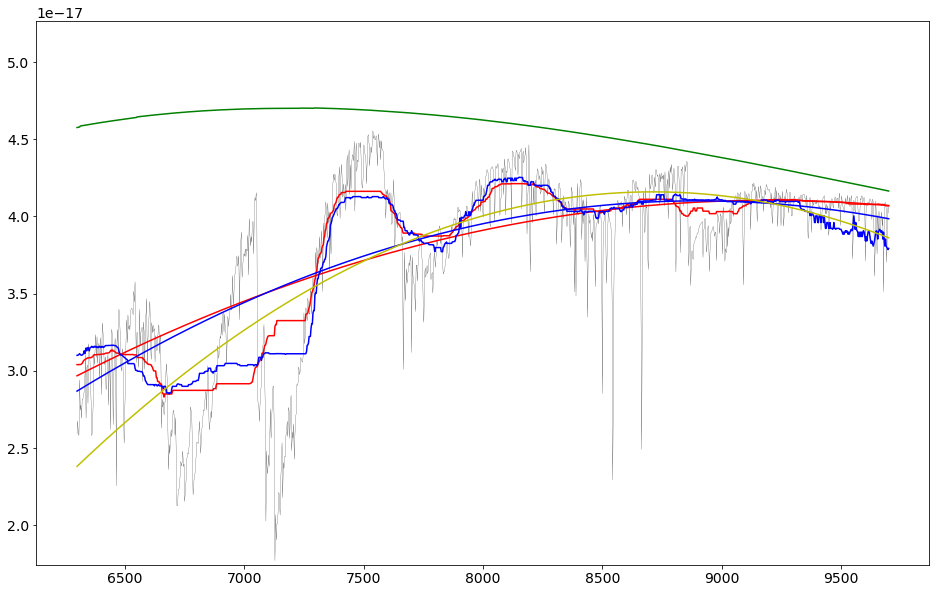

In [30]:
figure(figsize=(16, 10))
plot(spec.wave, spec.flux, lw=0.2, color='k')
#plot(spec.wave, noiz, lw=0.2, color='k')
plot(spec.wave, spec.cont, color='g')
plot(spec.wave, cont, '-r')
plot(spec.wave, cont_fit, '-r')
plot(spec.wave, ncnt, '-b')
plot(spec.wave, ncnt_fit, '-b')
plot(spec.wave, noiz_fit, '-y')

ylim(np.quantile(noiz, [0.05, 0.95]))

# Find continuum pixels

Generate noise, fit pixels with polynomial, then throw away outlying pixels, iterate

In [33]:
spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=4500, log_g=3, C_M=0, O_M=0)
filt = Filter()
filt.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/hsc/hsc_r.dat'))
spec.normalize_to_mag(filt, 20)

In [34]:
#nwave = np.arange(3800, 6500, 2.7)
nwave = np.arange(6300, 9700, 2.7)
#nwave = np.arange(9400, 12600, 2.7)
spec.rebin(nwave)

In [35]:
noise = Noise()
noise.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/pfs/noise/sim8hr.dat'))
noise.resample(spec.wave)

good:  1083
good:  941
good:  824
good:  708
good:  600
good:  521
good:  437
good:  373
good:  314
good:  269


((1260,), (1260,), 269)

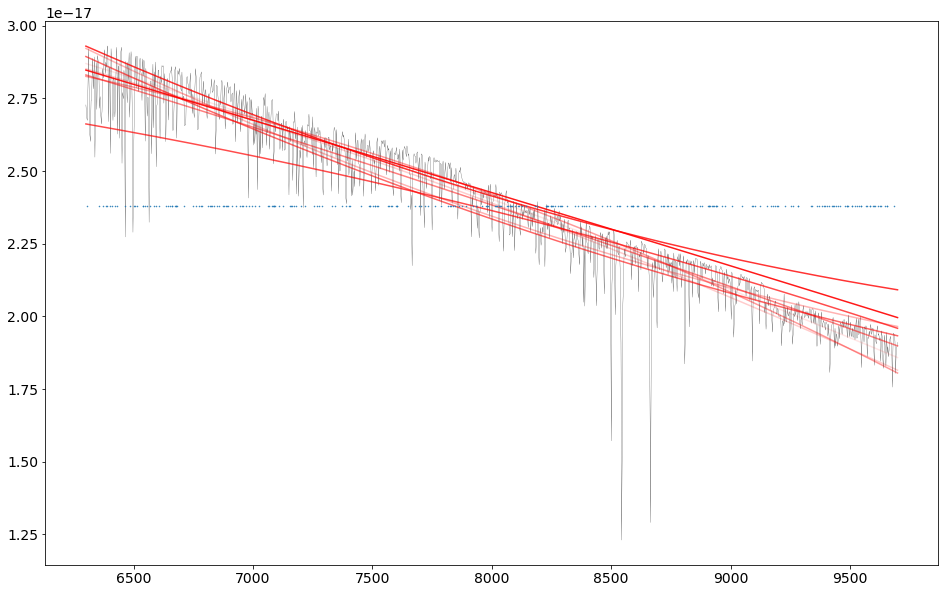

In [36]:
def fit(wave, mask, y, w):
    p = np.polyfit(wave[mask], y[mask], 2, w=w[mask])
    return np.polyval(p, wave)

mask = np.full(spec.wave.shape, True)

figure(figsize=(16, 10))
plot(spec.wave, spec.flux, lw=0.2, color='k')

N = 10
for i in range(N):
    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)
    noiz_fit = fit(spec.wave, mask, noiz, 1/noise.sigma)
    
    plot(spec.wave, noiz_fit, color='r', alpha=i/N)

    #print('diff: ', np.abs(noiz[mask] - noiz_fit[mask]))
    #print('noiz: ', noise.sigma[mask])
    
    outlier = np.where(np.abs(noiz - noiz_fit) > 1.5 * noise.sigma)
    
    #print('outl: ', outlier)
    
    mask[outlier] = False
    
    print('good: ', np.sum(mask))
    
plot(spec.wave[mask], np.full(np.sum(mask), np.mean(spec.flux)), '.', ms=1)

spec.wave.shape, mask.shape, np.sum(mask)

# Fit upper envelope of model spectrum

This method works sufficiently well for models above T=4000 K, below that strong TiO band appear

In [37]:
import scipy.signal

In [38]:
spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=3800, log_g=0.5, C_M=0, O_M=0)

In [39]:
filt = Filter()
filt.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/hsc/hsc_r.dat'))
spec.normalize_to_mag(filt, 20)

In [40]:
#nwave = np.arange(3800, 6500, 2.7)
nwave = np.arange(6300, 9700, 2.7)
#nwave = np.arange(9400, 12600, 2.7)
spec.rebin(nwave)

In [41]:
noise = Noise()
noise.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/pfs/noise/sim8hr.dat'))
noise.resample(spec.wave)
noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)

In [42]:
maxidx = scipy.signal.argrelmax(spec.flux, order=10)[0]

for i in range(5):
    print(maxidx.shape)
    p = np.polyfit(spec.wave[maxidx], spec.flux[maxidx], 2)
    cont = np.polyval(p, spec.wave)
    mask = np.std(spec.flux[maxidx] - cont[maxidx]) > abs(spec.flux[maxidx] - cont[maxidx])
    maxidx = maxidx[mask]

(52,)
(42,)
(30,)
(17,)
(13,)


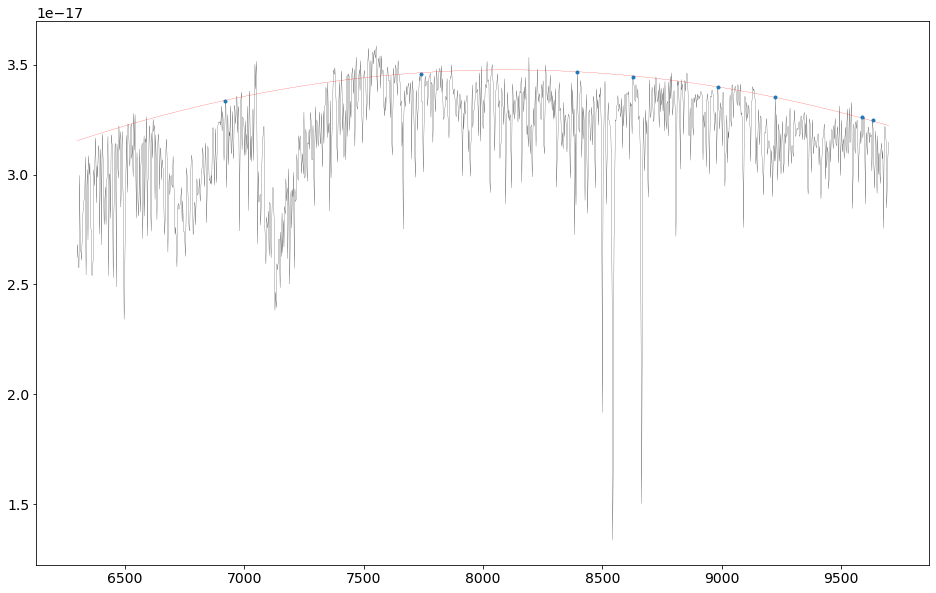

In [43]:
figure(figsize=(16, 10))
plot(spec.wave, spec.flux, lw=0.2, color='k')
plot(spec.wave, cont, lw=0.2, color='r')
plot(spec.wave[maxidx], spec.flux[maxidx], '.')

In [44]:
# Normalize with continuum

# of total pixels:  1260
# of continuum pixels:  120


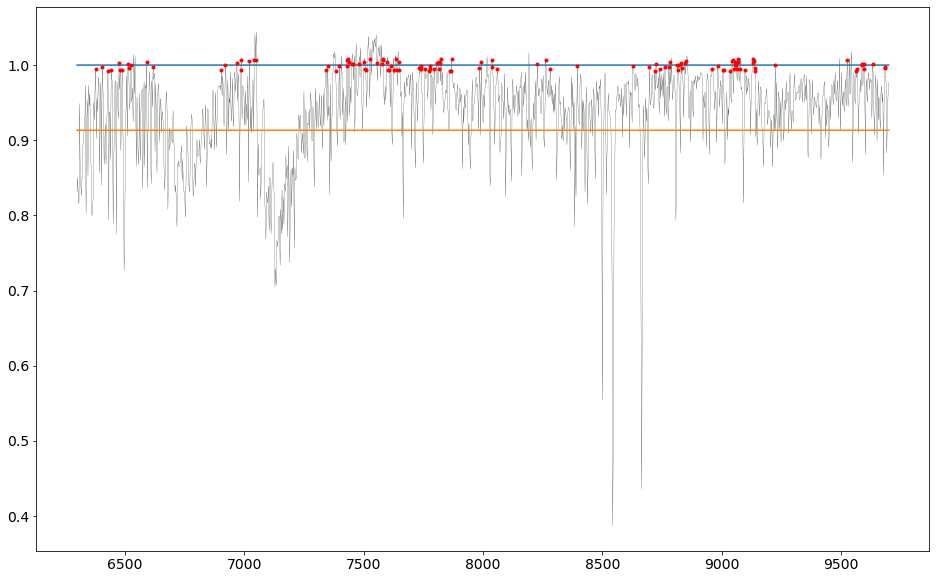

In [45]:
norm = spec.flux / cont

# Find "continuum" pixels
s = np.sqrt(np.mean(np.abs(norm - 1.0)**2))
contidx = np.abs(norm - 1.0) < 0.1 * s
print('# of total pixels: ', spec.wave.shape[0])
print('# of continuum pixels: ', np.sum(contidx))

figure(figsize=(16, 10))
plot(spec.wave, norm, lw=0.2, color='k')
plot(spec.wave, np.full(spec.wave.shape, 1.0))
plot(spec.wave, np.full(spec.wave.shape, 1.0 - s))
plot(spec.wave[contidx], norm[contidx], '.r')

# High-pass filtering method

* Take models at different temperatures
* Run high-pass filter
* Normalize with high-pass filtered "continuum"
* Look for variance in result as a function of wavelength

We expect that variance will be small when the effect of lines (and nearby lines) is small. Try to find these wavelengts or wavelength ranges and use the inverse variance to fit a smooth function to the continuum.

In [48]:
def high_pass_filter_test(Fe_H=-0.25, T_eff=4200, log_g=0.5, C_M=0, O_M=0, ext=1):
    filt = Filter()
    filt.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/hsc/hsc_r.dat'))
    
    spec = grid.get_nearest_model(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, C_M=C_M, O_M=O_M)
    spec.redden(ext)
    spec.normalize_to_mag(filt, 20)
    
    #nwave = np.arange(3800, 6500, 2.7)
    nwave = np.arange(6300, 9700, 2.7)
    #nwave = np.arange(9400, 12600, 2.7)
    spec.rebin(nwave)
    
    noise = Noise()
    noise.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/pfs/noise/sim8hr.dat'))
    noise.resample(spec.wave)
    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)
    
    dl = (50, 50)

    cont = Spectrum.running_filter(spec.wave, spec.flux, np.median, dlambda=dl)
    ncnt = Spectrum.running_filter(spec.wave, noiz, np.median, dlambda=dl)
    
    figure(figsize=(16, 10))
    plot(spec.wave, spec.flux, lw=0.2, color='k')
    plot(spec.wave, cont, lw=0.2, color='r')
    plot(spec.wave, ncnt, lw=0.2, color='b')

    ylim(np.min(spec.flux), np.max(spec.flux))
    
    figure(figsize=(16, 10))
    plot(spec.wave, noiz - cont, lw=0.2, color='k')
    plot(spec.wave, spec.flux - cont, lw=0.2, color='r')
    
    ylim(np.quantile(noiz - cont, [0.03, 0.97]))

    xlim(8000, 9000)

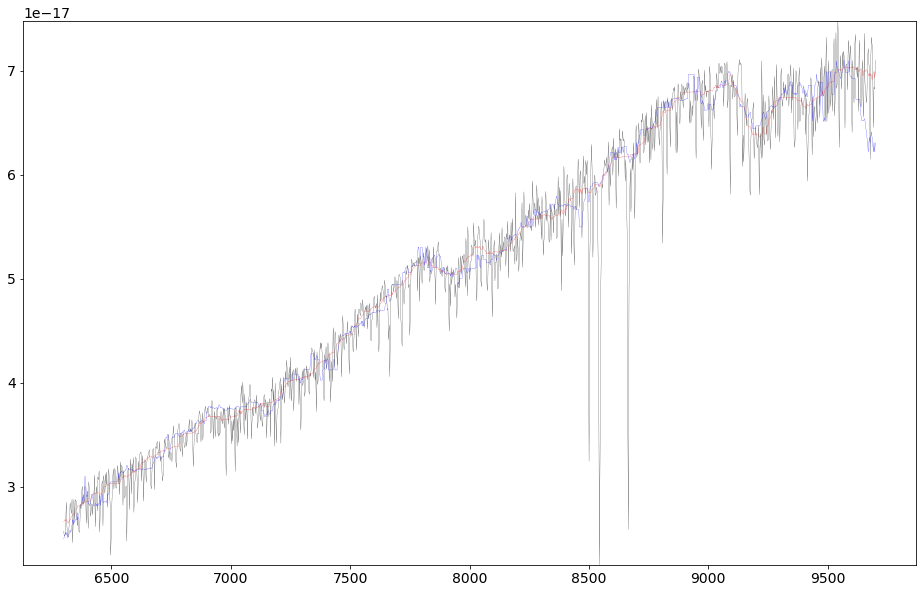

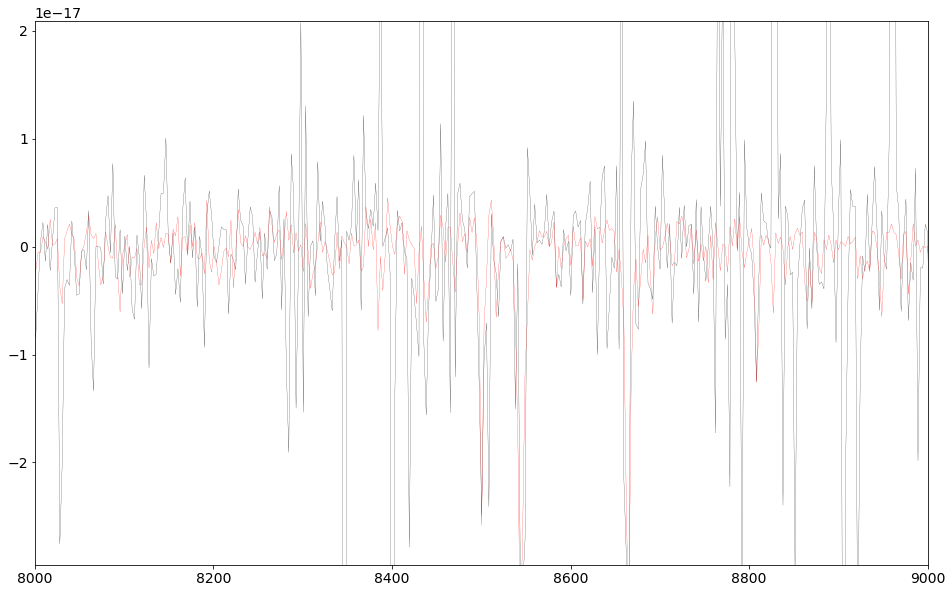

In [49]:
high_pass_filter_test()

### Variance of high-pass-filtered spectrum

In [53]:
dl = (50, 50)

nwave = np.arange(3820, 12600, 2.7)
#nwave = np.arange(3800, 6500, 2.7)
#nwave = np.arange(6300, 9700, 2.7)
#nwave = np.arange(9400, 12600, 2.7)

filt = Filter()
filt.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/hsc/hsc_r.dat'))

noise = Noise()
noise.read(os.path.join(os.environ['PFSSPEC_DATA'], 'subaru/pfs/noise/sim8hr.dat'))
noise.resample(nwave)

def get_high_pass_cont():
    t_eff = np.random.randint(3200, 5000)
    ext = np.random.lognormal(0.01, 0.5)
    mag = np.random.normal(19, 0.5)
    fe_h = np.random.uniform(-2.75, -0.25)
    spec = grid.get_nearest_model(Fe_H=fe_h, T_eff=t_eff, log_g=0.5, C_M=0, O_M=0)
    spec.redden(ext)
    spec.normalize_to_mag(filt, mag)
    spec.rebin(nwave)

    cont = Spectrum.running_filter(spec.wave, spec.flux, np.median, dlambda=dl)
    cont = spec.flux / cont

    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)
    
    ncnt = Spectrum.running_filter(spec.wave, noiz, np.median, dlambda=dl)
    
    #return spec.wave, spec.flux - cont, noiz - ncnt
    
    return noiz / ncnt

In [55]:
N = 20
ncnt = np.empty((N, ) + nwave.shape)
for i in range(N):
    ncnt[i] = get_high_pass_cont()

In [56]:
ncnt_var = np.std(ncnt, axis=0)
ncnt_min = np.min(ncnt_var)
ncnt_var.shape

(3252,)

(0, 0.18910867230442502)

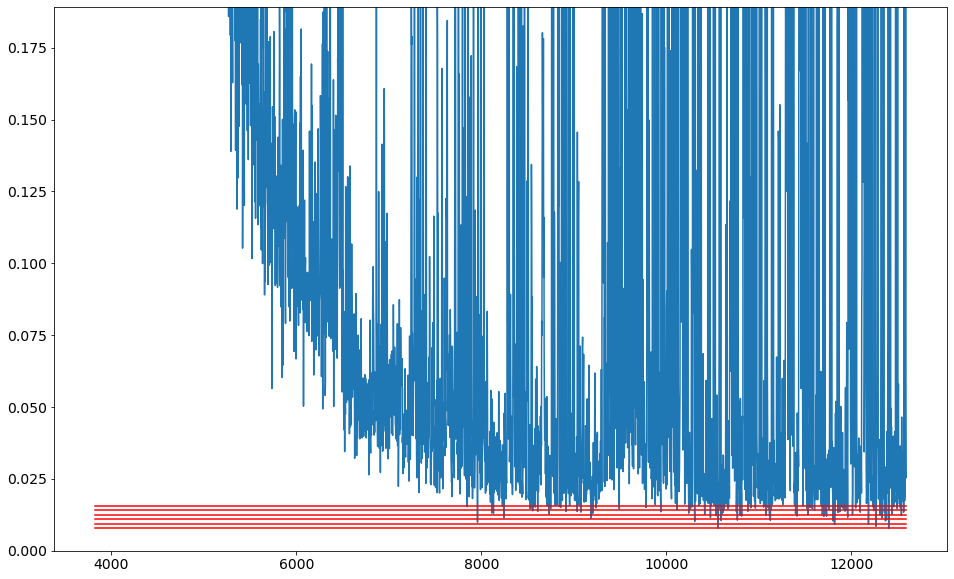

In [57]:
figure(figsize=(16, 10))
plot(nwave, ncnt_var)
for m in [1, 1.2, 1.4, 1.6, 1.8, 2.0]:
    plot([nwave[0], nwave[-1]], [m * ncnt_min, m * ncnt_min], 'r-')
ylim(0, np.quantile(ncnt_var, 0.7))

In [58]:
t = np.min(ncnt_var)
f = np.where(ncnt_var < t * 1.5)[0]
f.shape

(19,)

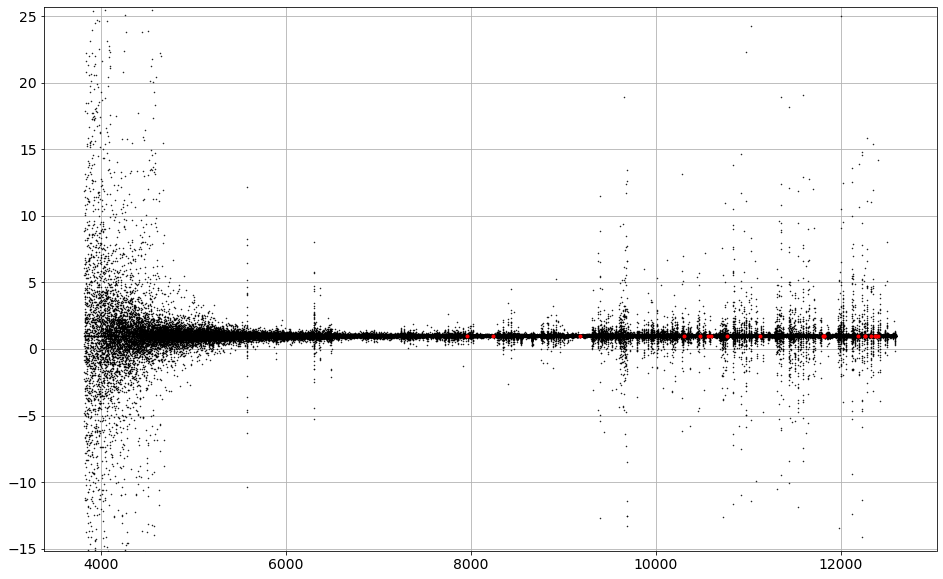

In [59]:
figure(figsize=(16, 10))

#plot(nwave, cont, '-r')
ylim(np.quantile(ncnt[1], [0.01, 0.99]))
#xlim(8300, 9000)

for i in range(ncnt.shape[0]):
    #plot(wave, ncnt, '-k', lw=0.2, alpha=0.5)
    plot(nwave, ncnt[i], '.k', ms=1)
    
plot(nwave[f], 1 + ncnt_var[f], 'r.')
#plot(nwave[f], np.full(len(f), 1.0))

plt.grid(True)

*IDEA:* Generate many spectra with noise, run smoothing, divide and look for pixels with low variance: these will be the continuum pixel. Repeat is over many realizations of all models.

*PROBLEMS:* 

* Continuum-normalized spectra "overshoot" around absorption lines and certain ranges with high noise or many lines
* Low-mass stars have strong TiO absorptions, what to do with those?

Once quasi-continuum pixels are identified, run some kind of fitting of a slowly changing function.

# Fit parametric model at well-behaving wavelengths

Using only 100% continuum pixels doesn't work, it won't constrain fits at the ends.

In [64]:
Fe_H = 0.0
T_eff = 5000
log_g = 5.0

In [65]:
spec = grid.get_nearest_model(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, C_M=0, O_M=0)
spec.redden(0.2)
spec.normalize_to_mag(filt, 19)
spec.rebin(nwave)

noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)

In [66]:
p = np.polyfit(spec.wave[f], noiz[f], 4)
cont = np.polyval(p, spec.wave)

(-0.4137496029260963, 2.4449993513132533)

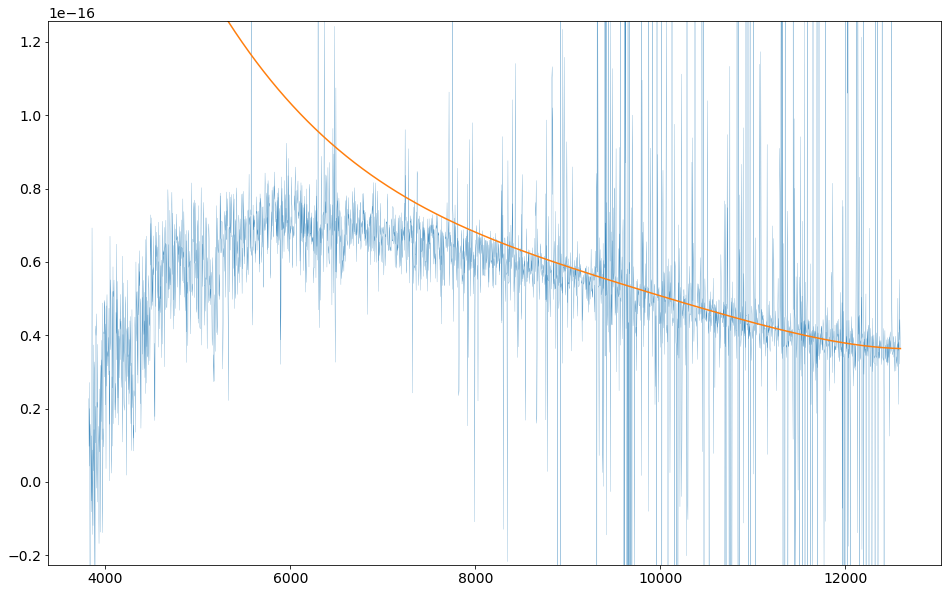

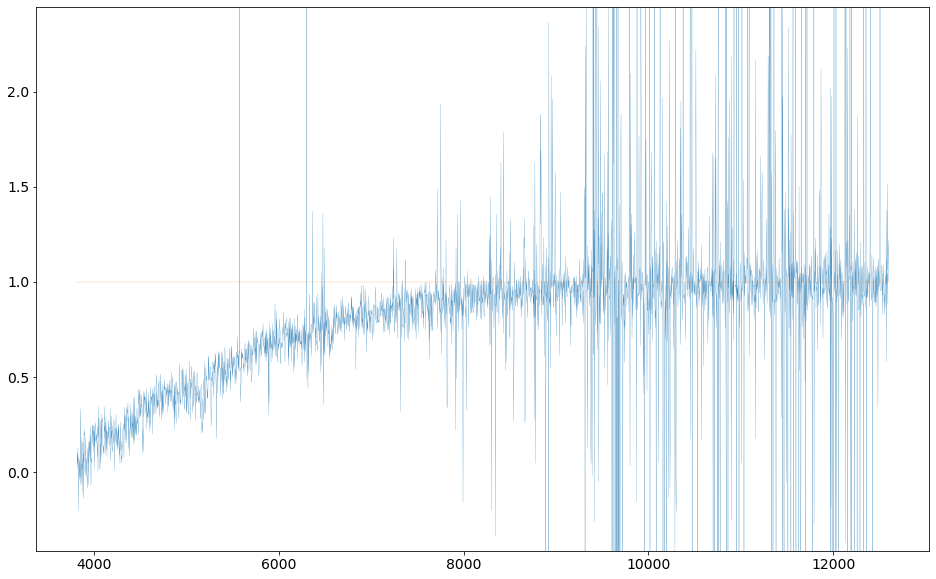

In [67]:
figure(figsize=(16, 10))
plot(spec.wave, noiz, lw=0.2)
plot(spec.wave, cont)

ylim(np.quantile(noiz, [0.02, 0.98]))

figure(figsize=(16, 10))
plot(spec.wave, noiz / cont, lw=0.2)
plot([spec.wave[0], spec.wave[-1]], [1, 1], lw=0.2)
ylim(np.quantile(noiz / cont, [0.02, 0.98]))

# Fit parametric model with weighting

Weigths are taken from the scatter of high-pass-filtered spectra

In [68]:
def fit_continuum(wave, flux, weight, order, method):
    if method == 'poly':
        p = np.polyfit(wave, flux, order, w=weight)
        cont = np.polyval(p, wave)
    elif method == 'cheby':
        p = numpy.polynomial.chebyshev.Chebyshev.fit(wave, flux, deg=order, w=weight)
        cont = p(wave)
    else:
        raise NotImplemented()
        
    return cont

In [70]:
spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=4000, log_g=0.5, C_M=0, O_M=0)
spec.redden(1)
spec.normalize_to_mag(filt, 19)
spec.rebin(nwave)

noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape)

### Fit polynomial

In [71]:
cont = fit_continuum(spec.wave, noiz, 1/np.sqrt(ncnt_var), 4, 'poly')

### Fit Chebyshev polinomials

In [72]:
cont = fit_continuum(spec.wave, noiz, 1/np.sqrt(ncnt_var), 4, 'cheby')

(-9.240807325362632e-18, 2.9385152139060495e-16)

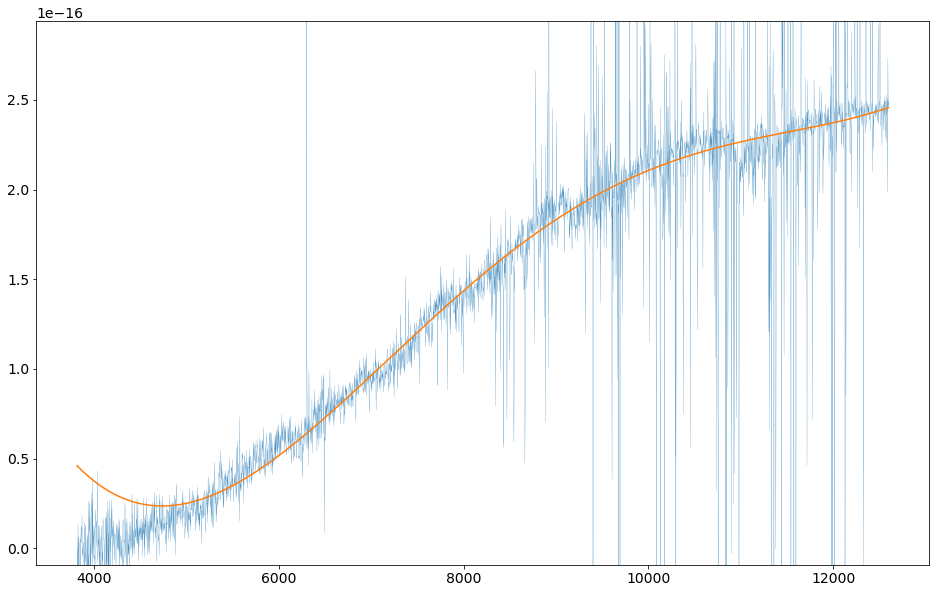

In [73]:
figure(figsize=(16, 10))
plot(spec.wave, noiz, lw=0.2)
plot(spec.wave, cont)

ylim(np.quantile(noiz, [0.02, 0.98]))

# Do bootstapping when fitting continuum to avoid outliers

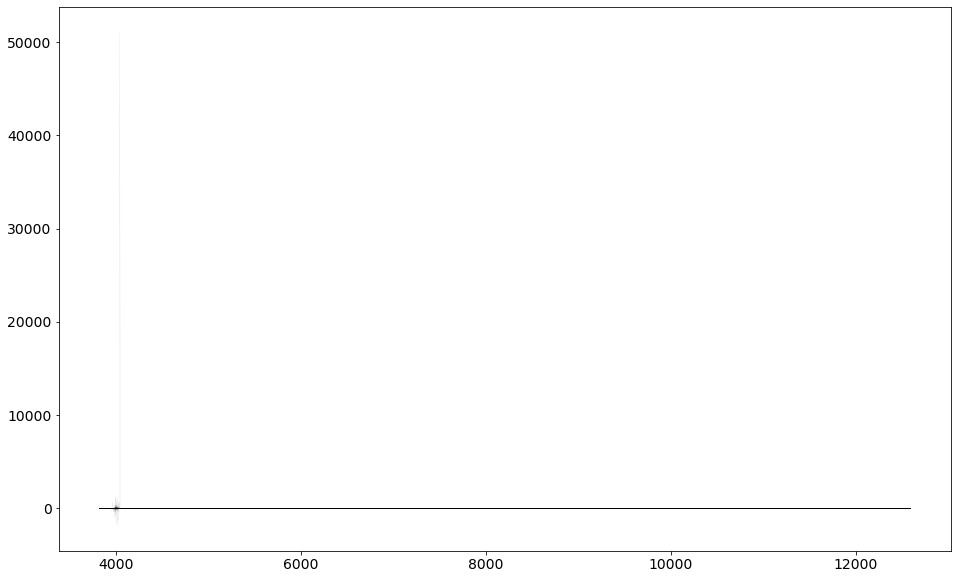

In [74]:
figure(figsize=(16, 10))

spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=3800, log_g=0.5, C_M=0, O_M=0)
spec.normalize_to_mag(filt, 19)
spec.rebin(nwave)

noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape) # * np.random.normal(1, 0.5)

for i in range(100):
    f = np.random.choice(spec.wave.shape[0], int(spec.wave.shape[0] * 0.8), replace=False)
    p = np.polyfit(spec.wave[f], noiz[f], 4, w=1/np.sqrt(ncnt_var[f]))
    cont = np.polyval(p, spec.wave)

    #plot(spec.wave, cont, 'k-', lw=0.2, alpha=0.3)
    
    #p = numpy.polynomial.chebyshev.Chebyshev.fit(spec.wave, noiz, deg=4, w=1/np.sqrt(ncnt_var))
    #cont = p(spec.wave)
    
    #plot(spec.wave, cont, 'r-', lw=0.2, alpha=0.3)
    
    plot(spec.wave, spec.flux / cont, 'k-', lw=0.1, alpha=0.3)

#plot(spec.wave, noiz, lw=0.2)
#ylim(np.quantile(noiz, [0.02, 0.98]))

## Look at stability of fit under varying extinction and noise

### Noiseless spectrum

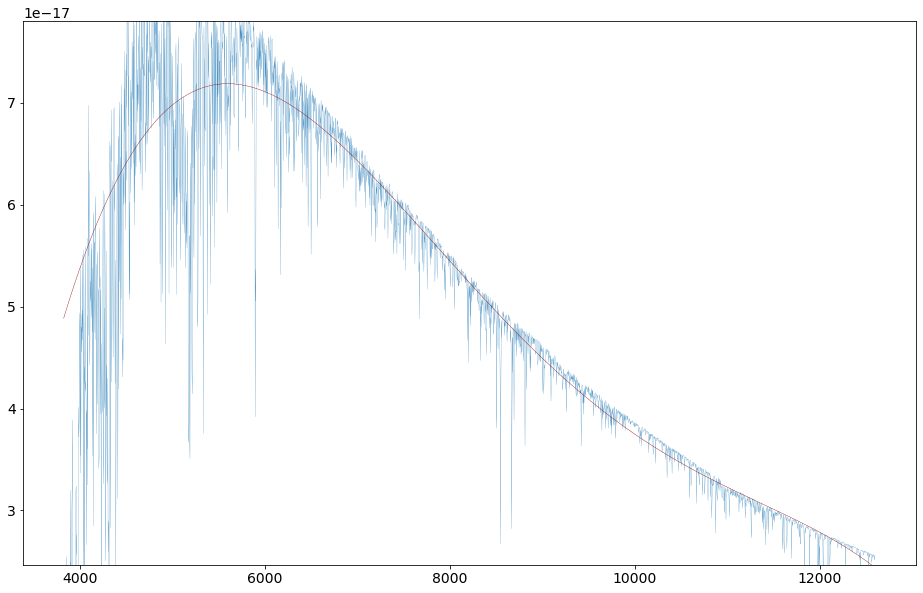

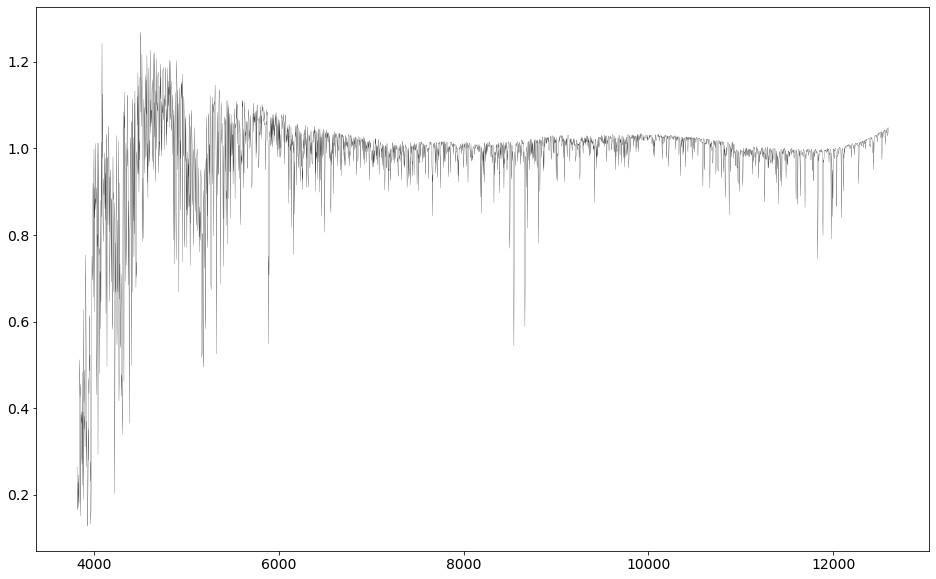

In [76]:
figure(figsize=(16, 10))
spec = grid.get_nearest_model(Fe_H=Fe_H, T_eff=T_eff, log_g=log_g, C_M=0, O_M=0)
spec.normalize_to_mag(filt, 19)
spec.rebin(nwave)
plot(spec.wave, spec.flux, lw=0.2)

p = np.polyfit(spec.wave, spec.flux, 4, w=1/np.sqrt(ncnt_var))
cont = np.polyval(p, spec.wave)
plot(spec.wave, cont, 'k-', lw=0.2)

p = numpy.polynomial.chebyshev.Chebyshev.fit(spec.wave, spec.flux, deg=4, w=1/np.sqrt(ncnt_var))
cont = p(spec.wave)
plot(spec.wave, cont, 'r-', lw=0.2)

ylim(np.quantile(spec.flux, [0.02, 0.98]))

figure(figsize=(16, 10))
plot(spec.wave, spec.flux/cont, 'k-', lw=0.2)

(-2.073506616712781e-17, 1.5072237169903945e-16)

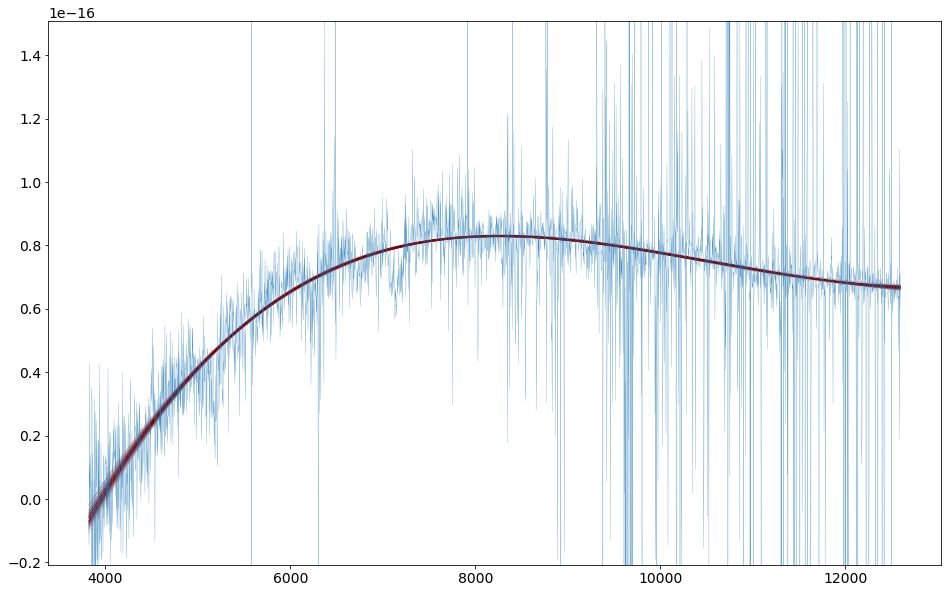

In [78]:
figure(figsize=(16, 10))

for i in range(100):
    spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=3800, log_g=0.5, C_M=0, O_M=0)
    spec.normalize_to_mag(filt, 19)
    spec.rebin(nwave)

    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape) # * np.random.normal(1, 0.5)

    p = np.polyfit(spec.wave, noiz, 4, w=1/np.sqrt(ncnt_var))
    cont = np.polyval(p, spec.wave)

    plot(spec.wave, cont, 'k-', lw=0.2, alpha=0.3)
    
    p = numpy.polynomial.chebyshev.Chebyshev.fit(spec.wave, noiz, deg=4, w=1/np.sqrt(ncnt_var))
    cont = p(spec.wave)
    
    plot(spec.wave, cont, 'r-', lw=0.2, alpha=0.3)

plot(spec.wave, noiz, lw=0.2)
ylim(np.quantile(noiz, [0.02, 0.98]))

(-1.6857508655474152, 3.677291278607432)

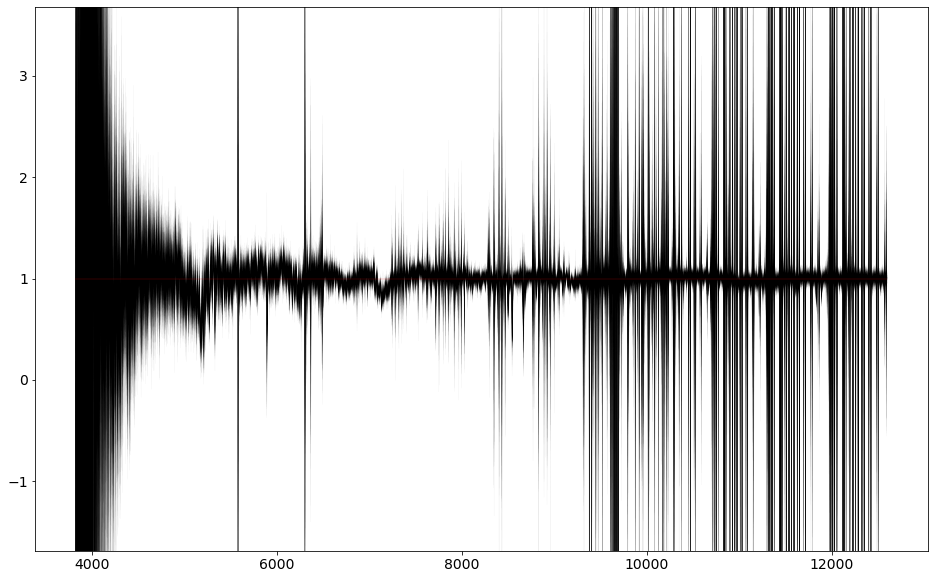

In [79]:
figure(figsize=(16, 10))

for i in range(100):
    spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=3800, log_g=0.5, C_M=0, O_M=0)
    spec.normalize_to_mag(filt, 19)
    spec.rebin(nwave)

    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape) # * np.random.normal(1, 0.5)

    p = np.polyfit(spec.wave, noiz, 4, w=1/np.sqrt(ncnt_var))
    cont = np.polyval(p, spec.wave)

    plot(spec.wave, noiz / cont, 'k-', lw=0.2, alpha=0.1)
    
    #p = numpy.polynomial.chebyshev.Chebyshev.fit(spec.wave, noiz, deg=4, w=1/np.sqrt(ncnt_var))
    #cont = p(spec.wave)
    
    #plot(spec.wave, noiz / cont, 'r-', lw=0.2, alpha=0.3)

#plot(spec.wave, noiz, lw=0.2)
plot([spec.wave[0], spec.wave[-1]], [1, 1], 'r-', lw=0.2)
ylim(np.quantile(noiz / cont, [0.02, 0.98]))

In [80]:
# Find wavelength range
idx = np.digitize((9500, 12500), spec.wave)
idx

array([2104, 3215])

17.965134534232234


(6800, 8500)

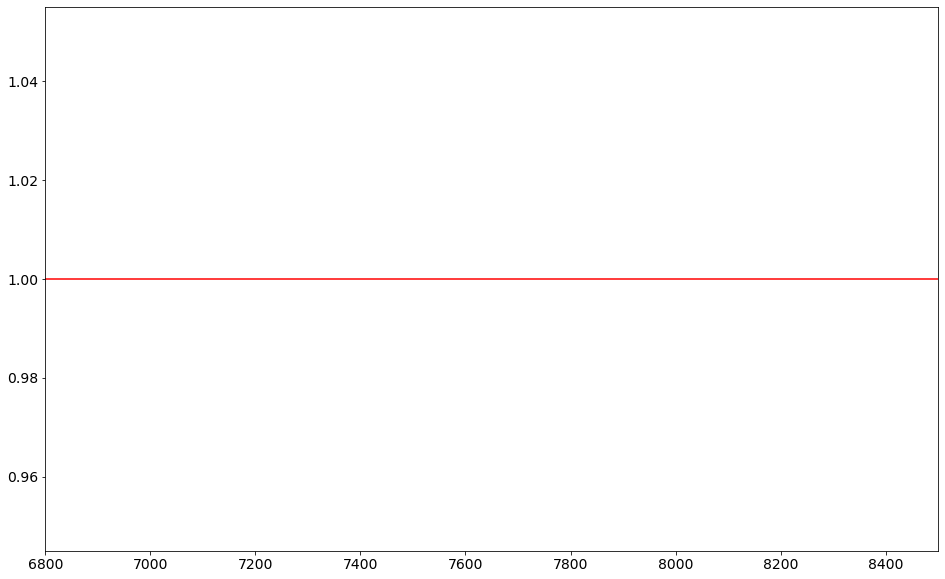

In [86]:
figure(figsize=(16, 10))

for i in range(100):
    mag = np.random.normal(19, 1)
    spec = grid.get_nearest_model(Fe_H=-0.25, T_eff=4000, log_g=1, C_M=0, O_M=0)
    #spec.redden(np.random.lognormal(0.01, 0.5))
    spec.normalize_to_mag(filt, mag)
    spec.rebin(nwave)

    noiz = spec.flux + noise.sigma * np.random.normal(size=spec.flux.shape) # * np.random.normal(1, 0.5)

    #p = np.polyfit(spec.wave, noiz, 4, w=1/ncnt_var)
    #cont = np.polyval(p, spec.wave)
    
    p = numpy.polynomial.chebyshev.Chebyshev.fit(spec.wave, noiz, deg=6, w=1/np.sqrt(ncnt_var))
    cont = p(spec.wave)

    #plot(spec.wave, noiz / cont, 'k.', ms=0.2, lw=0.2, alpha=0.3)
    
    chi2 = np.sum((spec.flux[idx[0]:idx[1]] / cont[idx[0]:idx[1]])**2 / np.sqrt(ncnt_var[idx[0]:idx[1]])) / (idx[1] - idx[0])
    mx = np.max(spec.flux[idx[0]:idx[1]] / cont[idx[0]:idx[1]])
    
    #if chi2 > 5:
    #    col = '-r'
    #else:
    #    col = '-k'
    
    if mx > 1.04:
        col = '-r'
        print(mag)
        break
    else:
        col = '-k'
    
    # Normalize original spectrum, not the noisy one!
    plot(spec.wave, spec.flux / cont, col, ms=0.2, lw=0.2, alpha=0.3)

#plot(spec.wave, noiz / cont, lw=0.2)
plot([spec.wave[0], spec.wave[-1]], [1, 1], 'r-')

#ylim(np.quantile(noiz / cont, [0.1, 0.9]))
xlim(6800, 8500)

### A spectrum with bad fit

This is a very noisy spectrum

(0.6456552565945352, 1.34202987336544)

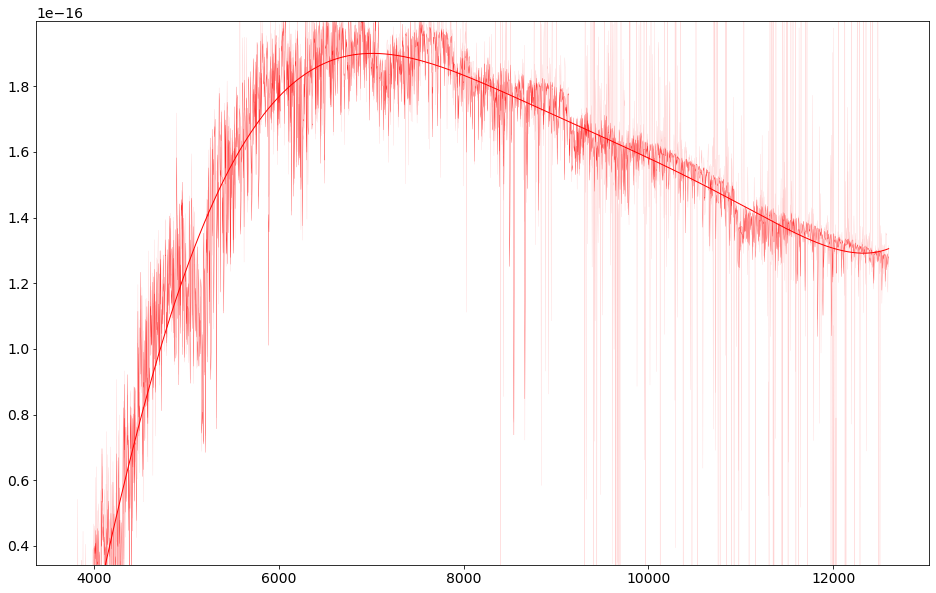

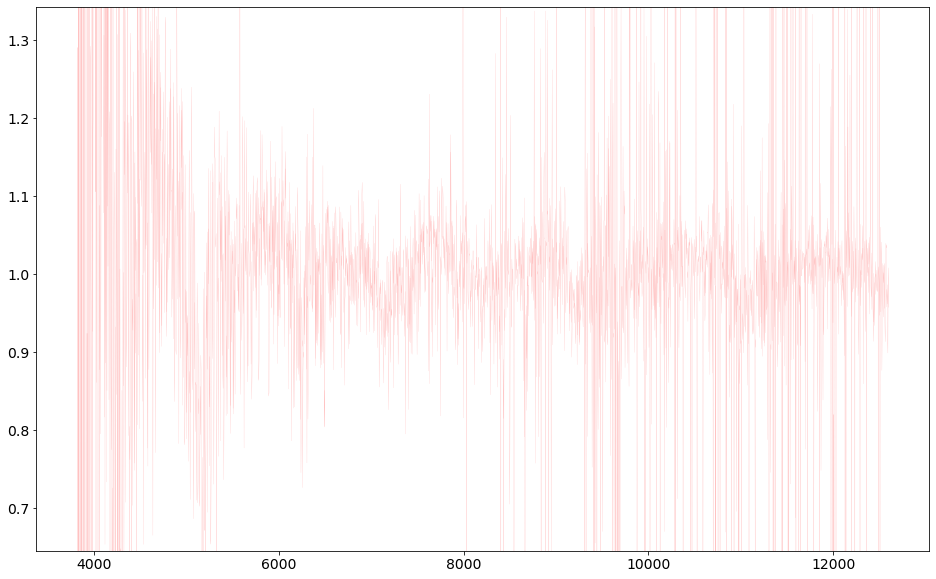

In [87]:
figure(figsize=(16, 10))

plot(spec.wave, noiz, col, ms=0.2, lw=0.2, alpha=0.3)
plot(spec.wave, spec.flux, col, ms=0.2, lw=0.2)
plot(spec.wave, cont, col, ms=0.2, lw=1)

ylim(np.quantile(noiz, [0.05, 0.95]))

figure(figsize=(16, 10))
plot(spec.wave, noiz / cont, col, ms=0.2, lw=0.2, alpha=0.3)
#plot(spec.wave, spec.flux / cont, col, ms=0.2, lw=0.2)
ylim(np.quantile(noiz / cont, [0.05, 0.95]))

# Try to normalize using Planck curve

In [108]:
def planck(wave, T):
    h = 6.626e-34
    c = 3.0e+8
    k = 1.38e-23
    a = 2.0 * h * c**2
    b = h * c / (wave * k * T)
    intensity = a / (wave**5 * (np.exp(b) - 1.0))
    return intensity

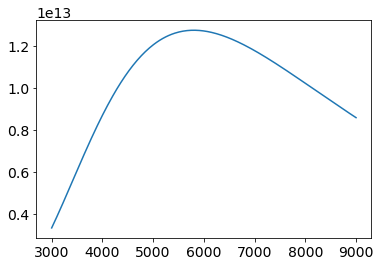

In [117]:
wave = np.linspace(3000, 9000, 300)
plot(wave, planck(wave/1e10, 5000))

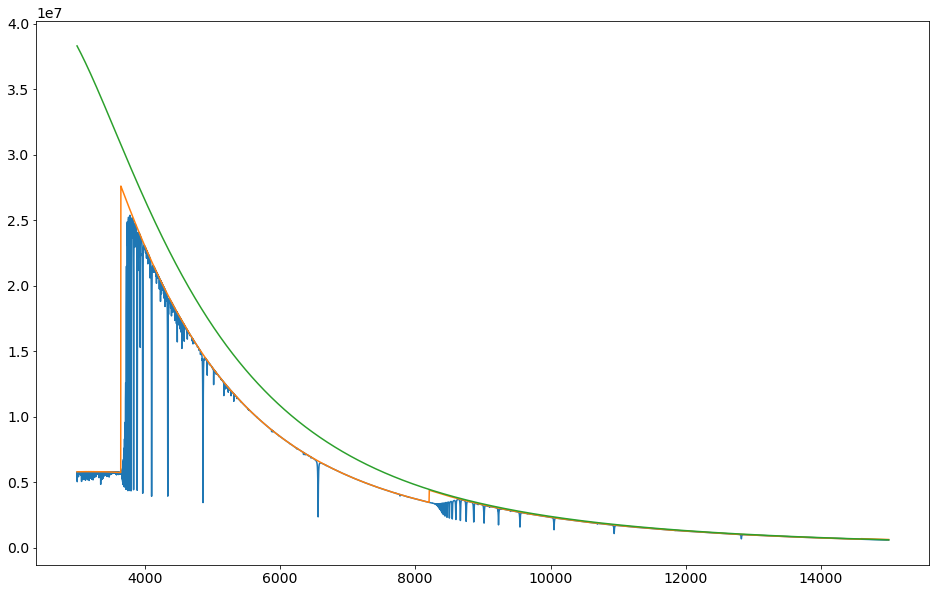

In [194]:
figure(figsize=(16, 10))

spec = grid.get_nearest_model(Fe_H=-2.0, T_eff=8000, log_g=1, C_M=0, O_M=0)

plot(spec.wave, spec.flux)
plot(spec.wave, spec.cont)
plot(spec.wave, planck(spec.wave*1e-10, 11500)*1e-7*0.5)
#plot(spec.wave, planck(spec.wave*1e-10, 4500)*1e-7*0.7, 'b-')

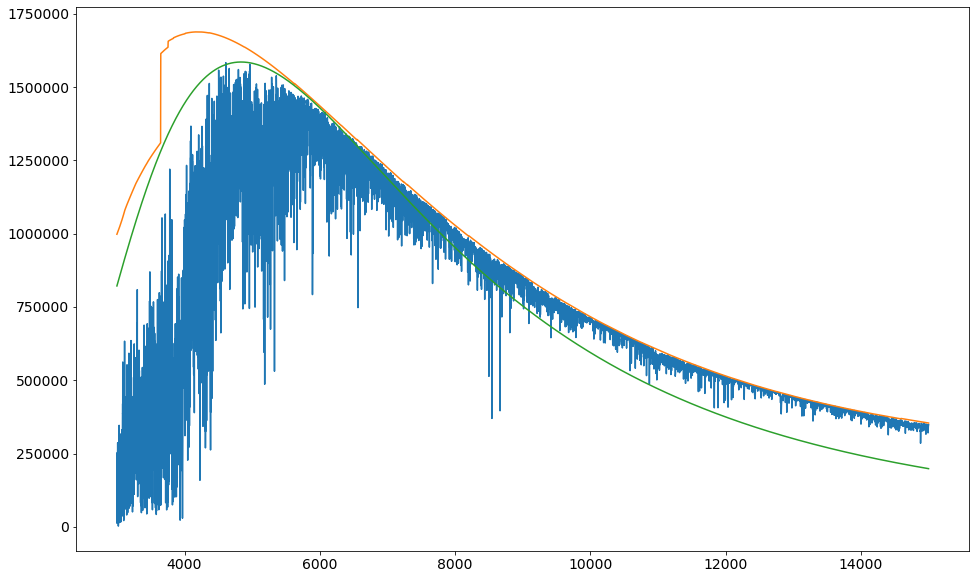

In [170]:
figure(figsize=(16, 10))

spec = grid.get_nearest_model(Fe_H=0.0, T_eff=5000, log_g=3, C_M=0, O_M=0)

plot(spec.wave, spec.flux)
plot(spec.wave, spec.cont)
plot(spec.wave, planck(spec.wave*1e-10, 6000)*1e-7*0.5)
#plot(spec.wave, planck(spec.wave*1e-10, 4500)*1e-7*0.7, 'b-')

In [153]:
import scipy.optimize

[ 2876 13863]
[8.72466789e-08 3.80202899e+03]


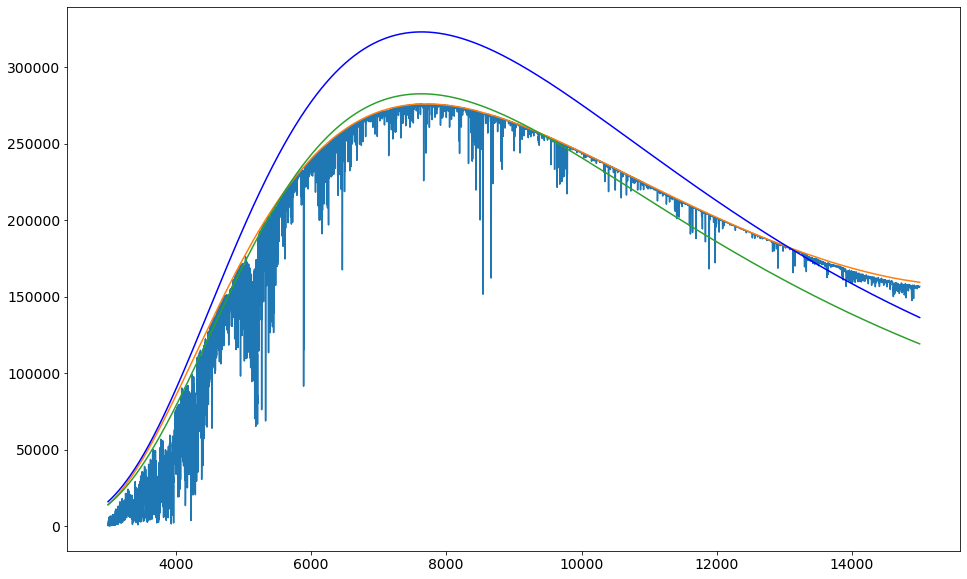

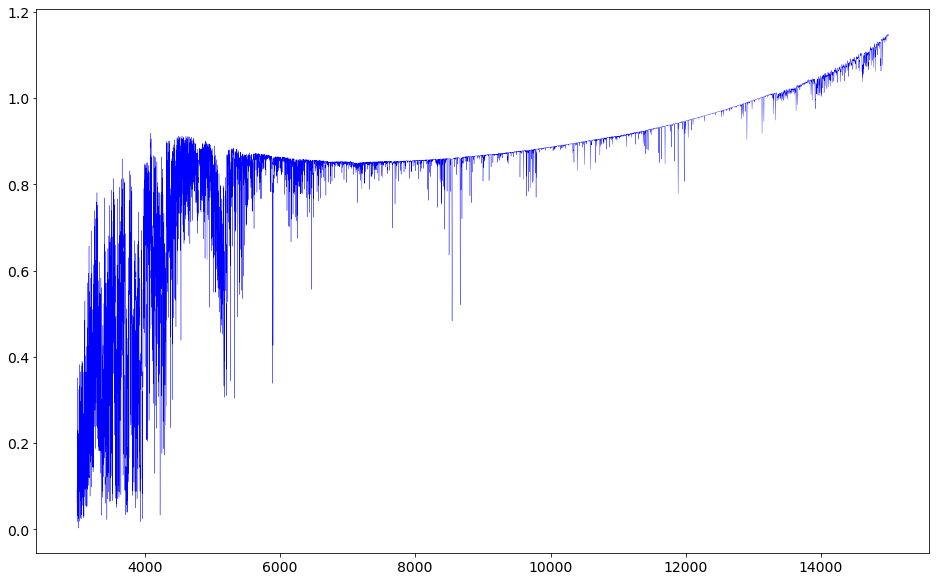

In [191]:
figure(figsize=(16, 10))

T_eff = 3800

spec = grid.get_nearest_model(Fe_H=-2.0, T_eff=T_eff, log_g=3, C_M=0, O_M=0)

#limit = np.digitize([8200, 13000], spec.wave)
limit = np.digitize([4000, 12000], spec.wave)
print(limit)
popt, pcov = scipy.optimize.curve_fit(lambda w, A, T: A * planck(w*1e-10, T), 
                                      spec.wave[limit[0]:limit[1]], 
                                      spec.cont[limit[0]:limit[1]], p0=[1e-7, T_eff])
print(popt)

plot(spec.wave, spec.flux)
plot(spec.wave, spec.cont)
plot(spec.wave, popt[0] * planck(spec.wave*1e-10, popt[1]))
#plot(spec.wave, planck(spec.wave*1e-10, 7000)*1e-7*0.1)
plot(spec.wave, planck(spec.wave*1e-10, T_eff)*1e-7, 'b-')

figure(figsize=(16, 10))
plot(spec.wave, spec.flux / planck(spec.wave*1e-10, T_eff) * 1e+7, 'b-', lw=0.3)

# Draw extinction from lognormal distribution

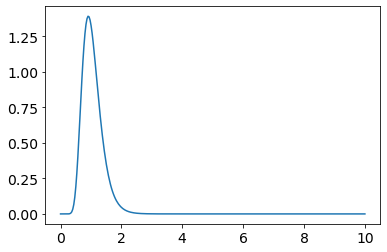

In [108]:
mu = 0
sigma = 0.3
x = linspace(0.001, 10, 300)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi)))
plot(x, pdf)